### This notebook extracts the sequences of miR1515 and 6478 from the melon genome. After this, the viri unique miRNAs are loaded to do the same

In [1]:
import matplotlib.pyplot as plt

In [2]:
def readFasta(file):
    """ Reads all sequences of a FASTA file 
        returns a dictionary """  
    dic = {}
    with open (file, 'r') as f:
        for line in f:
            line.strip()
            if line[0] == '>':
                end=line.index('\n')
                identifier=line[1:end]
                seq = ""
            else:
                seq = line[0:len(line)-1]
                dic.setdefault(identifier, []).append(seq)
    for key in dic:
        dic[key] = ''.join(dic[key])
        
    return dic

In [ ]:
genoma_melon = readFasta('/home/lab205/Desktop/datos_Raul/genoma_melon.fasta')

In [ ]:
genoma_melon.keys()

In [5]:
miR1515 = genoma_melon['chr11'][182625:182647]

In [6]:
miR6478 = genoma_melon['chr08'][26144712:26144733]

### To see a miRNA-generation profile we expand the coverage 200 bp along each direction (5' and 3')

In [7]:
miR1515 = genoma_melon['chr11'][182425:182847]

In [8]:
miR6478 = genoma_melon['chr08'][26144512:26144933]

### Write to a fasta file

In [9]:
fasta_file = open('/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/miR1515_miR6478_viri/fasta_1515_6478.fa', 'w')

In [10]:
fasta_file.write('>miR1515_prec\n')
fasta_file.write(miR1515)
fasta_file.write('\n')
fasta_file.write('>miR6478_prec\n')
fasta_file.write(miR6478)

421

In [11]:
fasta_file.close()

### Read the bowtie alignment file

In [12]:
import pandas as pd
import numpy as np
import re
import itertools
import ast

In [13]:
alignments_sRNA = pd.read_csv(
    '/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/bowtie_miR1515_6478.csv', sep = ',',
header = None)

/home/lab205/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,3,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
aligned_positions = pd.DataFrame(alignments_sRNA.iloc[4:])

## Drop rows with no alignment of a precursor to a read (*y)
drop_indeces = aligned_positions[aligned_positions.iloc[:,2] == '*']

In [15]:
aligned_positions = aligned_positions.drop(list(drop_indeces.index))

## If there is a flag "16" in the second column, it indicates that the alignment is with the reverse strand, so that we obtain back the reverse complement to get the counts

In [16]:
def complementary(gen):
    """ From a sequence of nucleotides return the inverse complementary
          e.g. GAACCT should return AGGTTC
          Hint: Use a dictionary for the translations
        """
    seq=""
    complement={"A":"T","T":"A","G":"C","C":"G",
                "K":"M","M":"K","B":"V","V":"B","S":"S","W":
                "W","Y":"R","R":"Y","D":"H","H":"D","N":"N"}
    for i in gen:
        comp=complement[i]
        seq=comp+seq
    return seq

In [17]:
complement_indeces = aligned_positions[aligned_positions.iloc[:,1] == '16'].index

In [18]:
count = 0
for seq in list(aligned_positions.loc[complement_indeces].iloc[:,9]):
    reverse = complementary(seq)
    aligned_positions = aligned_positions.replace(seq, reverse)

In [19]:
aligned_positions

0   1             2   \
7005   SNCMel000006999_C.SD_HSVd_D.SA_C.D_SD_C.SA_MON...  16  miR6478_prec   
23562  SNCMel000023558_D.MON_C.SA_D.SA_C.SA.SD_C_D_HS...  16  miR6478_prec   
24005  SNCMel000024001_SA_SD_MON_D_D.SA_C.SA_A_C_HSVd...  16  miR6478_prec   
28811  SNCMel000028806_MON_D_SA_D.SA_C.SA_D.MON_C.D_C...  16  miR6478_prec   
29545  SNCMel000029541_D_HSVd_C.SA.SD_D.MON_C.D_SD_SA...   0  miR1515_prec   
33445  SNCMel000033441_HSVd_A_SD_C.D_D_C.SD_MON_D.MON...  16  miR6478_prec   
35304  SNCMel000035300_C.SA_SD_MON_A_HSVd_D_C.SA.SD_D...  16  miR6478_prec   

        3      4    5  6    7    8                          9   \
7005   202  255.0  20M  *  0.0  0.0       CCGACCTTAGCTCAGTTGGT   
23562  200  255.0  22M  *  0.0  0.0     CCGACCTTAGCTCAGTTGGTAG   
24005  198  255.0  24M  *  0.0  0.0   CCGACCTTAGCTCAGTTGGTAGAG   
28811  197  255.0  25M  *  0.0  0.0  CCGACCTTAGCTCAGTTGGTAGAGC   
29545  201  255.0  22M  *  0.0  0.0     TCATTTTTGCGTGCAATGATCC   
33445  201  255.0  21M  *  0.0  0.0      CCGACCTTAGCTCAGTTGGTA   
35304  199  255.0  23M  *  0.0  0.0    CCGACCTTAGCTCAGTTGGTAGA   

                              10      11       12      13  
7005        IIIIIIIIIIIIIIIIIIII  XA:i:0  MD:Z:20  NM:i:0  
23562     IIIIIIIIIIIIIIIIIIIIII  XA:i:0  MD:Z:22  NM:i:0  
24005   IIIIIIIIIIIIIIIIIIIIIIII  XA:i:0  MD:Z:24  NM:i:0  
28811  IIIIIIIIIIIIIIIIIIIIIIIII  XA:i:0  MD:Z:25  NM:i:0  
29545     IIIIIIIIIIIIIIIIIIIIII  XA:i:0  MD:Z:22  NM:i:0  
33445      IIIIIIIIIIIIIIIIIIIII  XA:i:0  MD:Z:21  NM:i:0  
35304    IIIIIIIIIIIIIIIIIIIIIII  XA:i:0  MD:Z:23  NM:i:0

### Busco los SNCMels en la final_table_precursors_counts_diff_exp. Importamos las tablas de cuentas sin normalizar y sin pasar por RFAM, ya que, en caso de usar las tablas nuevas T4 filtradas por RFAM nos eliminaría los sRNAs que alinean con miR6478, al tratarse este último de un RNA de transferencia, presuntamente.

In [22]:
## Estreses simples T4
A = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/A.txt', sep = '\t')
C = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/C.txt', sep = '\t')
D = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/D.txt', sep = '\t')
SA = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/SA.txt', sep = '\t')
SD = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/SD.txt', sep = '\t')
HSVd = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/HSVd.txt', sep = '\t')
MON = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/MON.txt', sep = '\t')

## Estreses dobles y el triple T4
C_D = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/C.D.txt', sep = '\t')
C_SA_SD = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/C.SA.SD.txt', sep = '\t')
C_SA = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/C.SA.txt', sep = '\t')
C_SD = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/C.SD.txt', sep = '\t')
D_MON = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/D.MON.txt', sep = '\t')
D_SA = pd.read_csv('/home/lab205/Desktop/LLUIS/Analysis/archivos_julio_19/PCA-cuentas/D.SA.txt', sep = '\t')

In [23]:
### list of file names:
stresses_list_names = ['A','C', 'C_D', 'C_SA_SD', 'C_SA', 'C_SD', 'D', 'D_MON', 'D_SA', 'SA', 'SD', 'HSVd', 'MON']

### list of file names:
stresses_list = [A, C, C_D, C_SA_SD, C_SA, C_SD, D, D_MON, D_SA, SA, SD, HSVd, MON]

In [24]:
### Cada archivo tiene una longitud diferente, lo que significa que tenemos un número diferente de sRNAs expresados
# en cada librería, ranging from 40,000 to 70,000 app.

### Adding data from simple, double and triple stresses
""" I need to add 39 columns (3 replicates per each stress condition, i.e. 7 simple stresses,
5 double and 1 triple stresses).
"""
i = 0
tmp_df = stresses_list[i]
while i < len(stresses_list)-1:
    tmp_df = pd.merge(tmp_df, stresses_list[i+1], how = 'outer')
    i += 1

np.shape(tmp_df)

### Add mean counts for each stress condition

mean_ctrl = tmp_df.iloc[:,1:5]
mean_agro = tmp_df.iloc[:,[5,6]]
subset_stress_list = [mean_ctrl, mean_agro]

for name in stresses_list_names[1:]:
    i = stresses_list_names.index(name)
    index = 3 * stresses_list_names.index(name) ## 3 times, since there are three replicates per sample.
    #print(index)
    subset_stress = tmp_df.iloc[:, index + 4 : index + 7]
    subset_stress_list.append(subset_stress)

### 4 control samples
tmp_df.insert(loc = 5, column= 'MEAN-CONTROL',
                 value = mean_ctrl.mean(axis = 1))

### 2 Agro samples
tmp_df.insert(loc = 8, column= 'MEAN-AGRO',
                 value = mean_agro.mean(axis = 1))

index = 9
i = 1
for j in subset_stress_list[2:]: # Without Control and agro
    tmp_df.insert(loc = index + 3, column= 'MEAN-%s' %stresses_list_names[i],
                 value = j.mean(axis = 1))
    index += 4
    i += 1

## Final table

final_table = tmp_df

In [26]:
## Selection and change name of columns:
aligned_positions_no_mismatches = aligned_positions.iloc[:,[0,2,3,9]]
aligned_positions_no_mismatches.columns = ['sRNA identifier', 'Precursor', 'start', 'sequence']

In [27]:
## Creation of the dictionary with the length of the two precursors
lengths_precursors = pd.DataFrame(alignments_sRNA.iloc[:,[1,2]][1:3])
keys = []
values = []

for i in range(2):
    number = str(lengths_precursors.iloc[[i,]])
    length_miRNA = number.split(':')[-1:][0]
    id_miRNA = number.split(':')[1].split()[0]
    keys.append(id_miRNA)
    values.append(length_miRNA)

In [28]:
dictionary_precursors=dict(zip(keys, values))
dictionary_precursors

{'miR1515_prec': '422', 'miR6478_prec': '421'}

In [29]:
## Go back to the uploaded alignment file

sRNA_sncmels = [sRNA[0:15] for sRNA in aligned_positions_no_mismatches['sRNA identifier']]
new_table_reduced = aligned_positions_no_mismatches.iloc[:,1:] ### add length precursors (dict)
new_table_reduced['ID'] = sRNA_sncmels

new_table_reduced['length prec'] = [0]*len(new_table_reduced)
new_table_reduced.reset_index(inplace=True, drop = True)

for key in dictionary_precursors:
    for key2 in new_table_reduced['Precursor']:
        if key == key2:
            indeces = [i for i, x in enumerate(list(new_table_reduced['Precursor'])) if x == key2]
            for index in indeces:
                new_table_reduced['length prec'].iloc[index] = dictionary_precursors[key]

/home/lab205/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
new_table_reduced

Precursor start                   sequence               ID length prec
0  miR6478_prec   202       CCGACCTTAGCTCAGTTGGT  SNCMel000006999         421
1  miR6478_prec   200     CCGACCTTAGCTCAGTTGGTAG  SNCMel000023558         421
2  miR6478_prec   198   CCGACCTTAGCTCAGTTGGTAGAG  SNCMel000024001         421
3  miR6478_prec   197  CCGACCTTAGCTCAGTTGGTAGAGC  SNCMel000028806         421
4  miR1515_prec   201     TCATTTTTGCGTGCAATGATCC  SNCMel000029541         422
5  miR6478_prec   201      CCGACCTTAGCTCAGTTGGTA  SNCMel000033441         421
6  miR6478_prec   199    CCGACCTTAGCTCAGTTGGTAGA  SNCMel000035300         421

In [31]:
final_dataframe_diff_exp_sRNAs = pd.read_csv('/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/tablas/final_dataframe_diff_exp_sRNAs.csv')

In [32]:
final_table_precursors_sncmels = pd.merge(new_table_reduced, final_dataframe_diff_exp_sRNAs)

final_table_precursors_sncmels = final_table_precursors_sncmels.rename({'sequence':'sRNA'}, axis = 1)

In [33]:
final_table_precursors_sncmels

Precursor start                       sRNA               ID length prec  \
0  miR6478_prec   202       CCGACCTTAGCTCAGTTGGT  SNCMel000006999         421   
1  miR6478_prec   200     CCGACCTTAGCTCAGTTGGTAG  SNCMel000023558         421   
2  miR6478_prec   198   CCGACCTTAGCTCAGTTGGTAGAG  SNCMel000024001         421   
3  miR6478_prec   197  CCGACCTTAGCTCAGTTGGTAGAGC  SNCMel000028806         421   
4  miR1515_prec   201     TCATTTTTGCGTGCAATGATCC  SNCMel000029541         422   
5  miR6478_prec   201      CCGACCTTAGCTCAGTTGGTA  SNCMel000033441         421   
6  miR6478_prec   199    CCGACCTTAGCTCAGTTGGTAGA  SNCMel000035300         421   

          A         C       C_D   C_SA_SD      C_SA      C_SD         D  \
0       NaN       NaN       NaN       NaN -1.111494       NaN -0.669981   
1       NaN       NaN       NaN -1.286862       NaN       NaN       NaN   
2       NaN -1.994465 -2.123355 -2.746718 -1.500441 -2.104693       NaN   
3       NaN -1.374940 -1.331237 -2.372433 -1.476444 -1.454775 -1.093288   
4       NaN -2.465396 -1.851414 -2.062877 -1.926598 -1.814543       NaN   
5 -1.198489       NaN       NaN -1.492461       NaN       NaN -1.685021   
6       NaN -0.891729 -1.285686 -2.187689 -1.370495 -1.000755 -1.684189   

      D_MON      D_SA        SA  SD      HSVd  MON  
0       NaN -0.986704       NaN NaN       NaN  NaN  
1       NaN       NaN       NaN NaN       NaN  NaN  
2       NaN -1.457322       NaN NaN -2.139675  NaN  
3       NaN -1.618990       NaN NaN -1.748367  NaN  
4 -1.542243       NaN       NaN NaN       NaN  NaN  
5 -1.585159 -1.057698       NaN NaN -0.951368  NaN  
6       NaN -1.723576 -0.747905 NaN -1.620903  NaN

In [34]:
final_table_precursors_counts_diff_exp = pd.merge(final_table_precursors_sncmels, final_table)
final_table_precursors_counts_diff_exp

Precursor start                       sRNA               ID length prec  \
0  miR6478_prec   202       CCGACCTTAGCTCAGTTGGT  SNCMel000006999         421   
1  miR6478_prec   200     CCGACCTTAGCTCAGTTGGTAG  SNCMel000023558         421   
2  miR6478_prec   198   CCGACCTTAGCTCAGTTGGTAGAG  SNCMel000024001         421   
3  miR6478_prec   197  CCGACCTTAGCTCAGTTGGTAGAGC  SNCMel000028806         421   
4  miR1515_prec   201     TCATTTTTGCGTGCAATGATCC  SNCMel000029541         422   
5  miR6478_prec   201      CCGACCTTAGCTCAGTTGGTA  SNCMel000033441         421   
6  miR6478_prec   199    CCGACCTTAGCTCAGTTGGTAGA  SNCMel000035300         421   

          A         C       C_D   C_SA_SD      C_SA  ...    SD-3      MEAN-SD  \
0       NaN       NaN       NaN       NaN -1.111494  ...   161.0   158.666667   
1       NaN       NaN       NaN -1.286862       NaN  ...   134.0   132.333333   
2       NaN -1.994465 -2.123355 -2.746718 -1.500441  ...    42.0    30.333333   
3       NaN -1.374940 -1.331237 -2.372433 -1.476444  ...   130.0   109.333333   
4       NaN -2.465396 -1.851414 -2.062877 -1.926598  ...     8.0     8.666667   
5 -1.198489       NaN       NaN -1.492461       NaN  ...   810.0   676.666667   
6       NaN -0.891729 -1.285686 -2.187689 -1.370495  ...  1938.0  1679.666667   

   HSVd-1  HSVd-2  HSVd-3   MEAN-HSVd  MON-1  MON-2   MON-3    MEAN-MON  
0   183.0   228.0   261.0  224.000000   77.0  191.0   190.0  152.666667  
1   114.0    96.0   179.0  129.666667   39.0  129.0   268.0  145.333333  
2     4.0    15.0    13.0   10.666667    8.0   15.0    31.0   18.000000  
3    65.0    59.0    69.0   64.333333   52.0  100.0   163.0  105.000000  
4    18.0     8.0    15.0   13.666667   21.0   24.0    23.0   22.666667  
5   649.0   664.0   882.0  731.666667  227.0  413.0  1008.0  549.333333  
6   654.0   692.0   819.0  721.666667  437.0  698.0  1668.0  934.333333  

[7 rows x 74 columns]

In [35]:
final_table_precursors_counts_diff_exp.to_csv('/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/tablas/tabla_1515_6478.csv', index = False)

### Sacar gráficas

In [36]:
sequences_list_T4 = final_table_precursors_counts_diff_exp['sRNA']
length_sequences_T4 = [len(i) for i in sequences_list_T4]

In [37]:
final_table_precursors_counts_diff_exp.insert(value = length_sequences_T4, column='length seq', loc=3)

In [38]:
final_table_precursors_counts_diff_exp

Precursor start                       sRNA  length seq               ID  \
0  miR6478_prec   202       CCGACCTTAGCTCAGTTGGT          20  SNCMel000006999   
1  miR6478_prec   200     CCGACCTTAGCTCAGTTGGTAG          22  SNCMel000023558   
2  miR6478_prec   198   CCGACCTTAGCTCAGTTGGTAGAG          24  SNCMel000024001   
3  miR6478_prec   197  CCGACCTTAGCTCAGTTGGTAGAGC          25  SNCMel000028806   
4  miR1515_prec   201     TCATTTTTGCGTGCAATGATCC          22  SNCMel000029541   
5  miR6478_prec   201      CCGACCTTAGCTCAGTTGGTA          21  SNCMel000033441   
6  miR6478_prec   199    CCGACCTTAGCTCAGTTGGTAGA          23  SNCMel000035300   

  length prec         A         C       C_D   C_SA_SD  ...    SD-3  \
0         421       NaN       NaN       NaN       NaN  ...   161.0   
1         421       NaN       NaN       NaN -1.286862  ...   134.0   
2         421       NaN -1.994465 -2.123355 -2.746718  ...    42.0   
3         421       NaN -1.374940 -1.331237 -2.372433  ...   130.0   
4         422       NaN -2.465396 -1.851414 -2.062877  ...     8.0   
5         421 -1.198489       NaN       NaN -1.492461  ...   810.0   
6         421       NaN -0.891729 -1.285686 -2.187689  ...  1938.0   

       MEAN-SD  HSVd-1  HSVd-2  HSVd-3   MEAN-HSVd  MON-1  MON-2   MON-3  \
0   158.666667   183.0   228.0   261.0  224.000000   77.0  191.0   190.0   
1   132.333333   114.0    96.0   179.0  129.666667   39.0  129.0   268.0   
2    30.333333     4.0    15.0    13.0   10.666667    8.0   15.0    31.0   
3   109.333333    65.0    59.0    69.0   64.333333   52.0  100.0   163.0   
4     8.666667    18.0     8.0    15.0   13.666667   21.0   24.0    23.0   
5   676.666667   649.0   664.0   882.0  731.666667  227.0  413.0  1008.0   
6  1679.666667   654.0   692.0   819.0  721.666667  437.0  698.0  1668.0   

     MEAN-MON  
0  152.666667  
1  145.333333  
2   18.000000  
3  105.000000  
4   22.666667  
5  549.333333  
6  934.333333  

[7 rows x 75 columns]

In [39]:
list_precursors = set(list(final_table_precursors_counts_diff_exp['Precursor']))

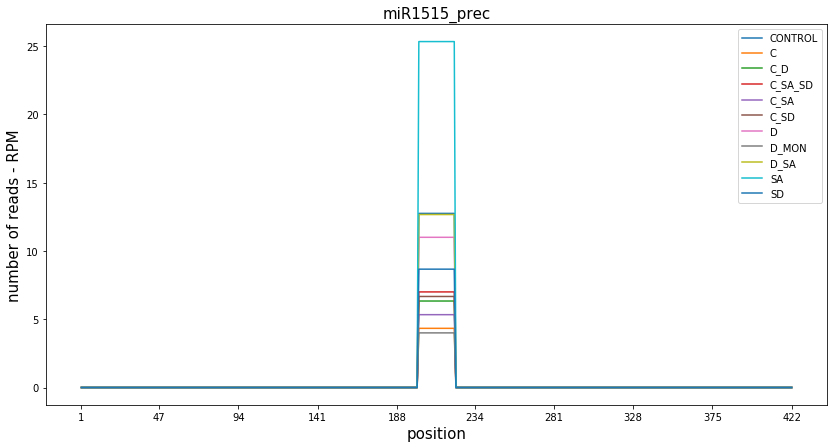

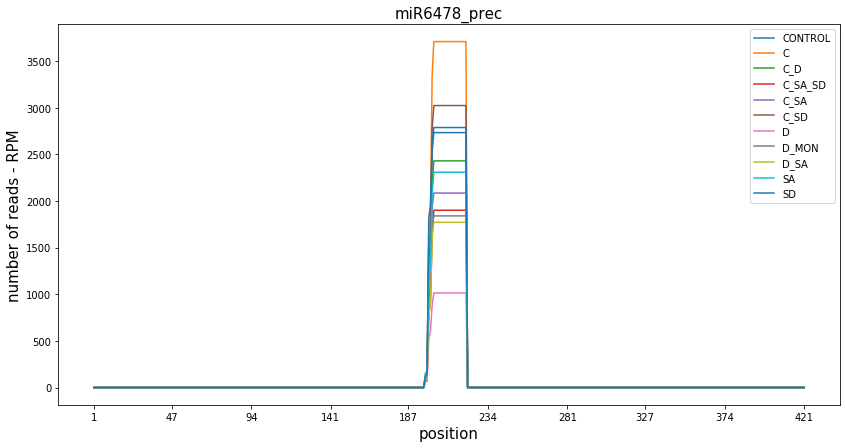

In [40]:
for precursor_cme in list_precursors:
    rows_precursor = set([prec for prec in list(final_table_precursors_counts_diff_exp['Precursor']) if precursor_cme in prec])
    cmels = final_table_precursors_counts_diff_exp.loc[final_table_precursors_counts_diff_exp['Precursor'].isin(rows_precursor)]
    length_col = [i for i in range(1, int(cmels['length prec'].iloc[0])+1)] ## for desde 1 hasta 134 (len prec.)
    column_names = ['CONTROL', 'C', 'C_D', 'C_SA_SD', 'C_SA', 'C_SD', 'D', 'D_MON', 'D_SA', 'SA', 'SD']
    
    base_to_base_prec_dataframe = pd.DataFrame(index=length_col, columns=column_names)
    base_to_base_prec_dataframe = base_to_base_prec_dataframe.fillna(0)

    mean_counts_names = [x for i,x in enumerate(cmels.columns) if 'MEAN' in x]

    mean_counts_names.insert(0,'start')
    mean_counts_names.insert(1,'length seq')
    mean_counts_names

    data = cmels[mean_counts_names]

    new_colnames = [x[5:] for i,x in enumerate(cmels.columns) if 'MEAN' in x]

    mean_counts_names[2:] = new_colnames

    data.columns = mean_counts_names

    try:
        for row in range(len(data)):
            start_pos = int(list(data.iloc[row,:])[0])
            end_pos = start_pos + int(list(data.iloc[row,:])[1])
            for base in range(start_pos, end_pos): 
                # Le resto 1 porque la lista de bases en el df empieza en la posición 0, no 1
                base_to_base_prec_dataframe.iloc[base-1] = base_to_base_prec_dataframe.iloc[base-1].fillna(0) + data.iloc[row][mean_counts_names[2:]].fillna(0)
    except:
        print('%s has given an error indexing in line 29' %precursor_cme)
    base_to_base_prec_dataframe = base_to_base_prec_dataframe.fillna(0) # cambiamos NA por 0

    plt.figure(figsize = (14,7))
    for i in base_to_base_prec_dataframe.columns:
         plt.plot(base_to_base_prec_dataframe.loc[:,i], label = i)

    plt.title('%s' %precursor_cme, fontsize = 15)
    plt.xlabel('position', fontsize = 15)
    plt.xticks(np.linspace(1,len(base_to_base_prec_dataframe),10, dtype = int))
    plt.ylabel('number of reads - RPM', fontsize = 15)
    plt.legend()
    plt.savefig('/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/miR1515_miR6478_viri/%s.jpg' %precursor_cme)


# Viri miRNAs. 
Load the bowtie alignment file

In [41]:
alignments_viri_precursors = pd.read_csv(
    '/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/bowtie_viri.csv', sep = ',',
header = None)

In [42]:
aligned_positions_viri = pd.DataFrame(alignments_viri_precursors.iloc[15:])

In [43]:
## Drop rows with no alignment of a precursor to a read (*y)
drop_indeces_viri = aligned_positions_viri[aligned_positions_viri.iloc[:,2] == '*']

In [44]:
aligned_positions_viri = aligned_positions_viri.drop(list(drop_indeces_viri.index))

## If there is a flag "16" in the second column, it indicates that the alignment is with the reverse strand, so that we obtain back the reverse complement to get the counts

In [45]:
complement_indeces_viri = aligned_positions_viri[aligned_positions_viri.iloc[:,1] == '16'].index

In [46]:
count = 0
for seq in list(aligned_positions_viri.loc[complement_indeces_viri].iloc[:,9]):
    reverse = complementary(seq)
    aligned_positions_viri = aligned_positions_viri.replace(seq, reverse)

In [47]:
aligned_positions_viri

0   1      2         3      4    5  6    7    8   \
16     viri2-miR156-15   0  chr11   7858606  255.0  22M  *  0.0  0.0   
17     viri2-miR156-15   0  chr07    744527  255.0  22M  *  0.0  0.0   
18     viri2-miR156-15   0  chr11   7892551  255.0  22M  *  0.0  0.0   
19     viri2-miR156-15   0  chr08  31093392  255.0  22M  *  0.0  0.0   
20     viri2-miR156-15  16  chr02  15766762  255.0  22M  *  0.0  0.0   
21     viri2-miR159-13  16  chr12  24780834  255.0  21M  *  0.0  0.0   
22      viri2-miR159-4  16  chr09  22510087  255.0  21M  *  0.0  0.0   
23      viri2-miR159-5  16  chr12  24780792  255.0  21M  *  0.0  0.0   
24     viri2-miR166-12  16  chr08  20264167  255.0  22M  *  0.0  0.0   
25     viri2-miR166-12  16  chr05   3795702  255.0  22M  *  0.0  0.0   
26     viri2-miR166-13  16  chr05   5180308  255.0  21M  *  0.0  0.0   
28      viri2-miR167-2  16  chr06   3607777  255.0  21M  *  0.0  0.0   
29      viri2-miR168-2  16  chr07   7334838  255.0  22M  *  0.0  0.0   
30      viri2-miR168-2  16  chr07  20509815  255.0  22M  *  0.0  0.0   
31      viri2-miR168-5  16  chr07   7334973  255.0  22M  *  0.0  0.0   
32      viri2-miR168-5  16  chr07  20509984  255.0  22M  *  0.0  0.0   
33      viri2-miR172-4   0  chr03  22171678  255.0  21M  *  0.0  0.0   
34      viri2-miR319-1   0  chr10  13694450  255.0  21M  *  0.0  0.0   
35     viri2-miR395-10   0  chr10   2794451  255.0  21M  *  0.0  0.0   
36     viri2-miR395-10   0  chr09   7497571  255.0  21M  *  0.0  0.0   
37     viri2-miR395-10  16  chr10   2791560  255.0  21M  *  0.0  0.0   
38     viri2-miR395-10  16  chr09   7582721  255.0  21M  *  0.0  0.0   
39     viri2-miR395-10  16  chr09   7557065  255.0  21M  *  0.0  0.0   
40     viri2-miR395-10  16  chr10   2787312  255.0  21M  *  0.0  0.0   
41      viri2-miR396-2  16  chr02  16926219  255.0  20M  *  0.0  0.0   
42      viri2-miR396-9  16  chr05  27560679  255.0  20M  *  0.0  0.0   
43      viri-miR1515-2   0  chr11    182626  255.0  22M  *  0.0  0.0   
46      viri-miR156-32   0  chr07    744467  255.0  21M  *  0.0  0.0   
47      viri-miR156-32  16  chr02  15766826  255.0  21M  *  0.0  0.0   
48      viri-miR156-32  16  chr05  27176762  255.0  21M  *  0.0  0.0   
..                 ...  ..    ...       ...    ...  ... ..  ...  ...   
140     viri-miR319-32   0  chr10  13694603  255.0  21M  *  0.0  0.0   
141     viri-miR319-40   0  chr09  19131023  255.0  20M  *  0.0  0.0   
143  viri-miR395-44-3p   0  chr09   7497571  255.0  20M  *  0.0  0.0   
144  viri-miR395-44-3p   0  chr10   2794451  255.0  20M  *  0.0  0.0   
145  viri-miR395-44-3p  16  chr10   2787313  255.0  20M  *  0.0  0.0   
146  viri-miR395-44-3p  16  chr10   2791561  255.0  20M  *  0.0  0.0   
147  viri-miR395-44-3p  16  chr09   7582722  255.0  20M  *  0.0  0.0   
148  viri-miR395-44-3p  16  chr09   7557066  255.0  20M  *  0.0  0.0   
149  viri-miR396-11-3p   0  chr07  18841192  255.0  21M  *  0.0  0.0   
153     viri-miR396-18   0  chr05  27552482  255.0  20M  *  0.0  0.0   
154     viri-miR396-18   0  chr02  16913636  255.0  20M  *  0.0  0.0   
155     viri-miR396-18  16  chr02  16926304  255.0  20M  *  0.0  0.0   
156     viri-miR396-18  16  chr02  16919634  255.0  20M  *  0.0  0.0   
157   viri-miR396-2-3p   0  chr02  16913749  255.0  21M  *  0.0  0.0   
158   viri-miR396-2-3p  16  chr05  27560545  255.0  21M  *  0.0  0.0   
160   viri-miR396-4-3p  16  chr02  16926219  255.0  21M  *  0.0  0.0   
162   viri-miR396-5-3p   0  chr07  18841192  255.0  20M  *  0.0  0.0   
163   viri-miR396-5-3p   0  chr02  16913749  255.0  20M  *  0.0  0.0   
164   viri-miR396-5-3p  16  chr05  27560546  255.0  20M  *  0.0  0.0   
165   viri-miR396-9-3p   0  chr02  16913750  255.0  20M  *  0.0  0.0   
166   viri-miR396-9-3p  16  chr05  27560545  255.0  20M  *  0.0  0.0   
167     viri-miR397-18   0  chr12  21929039  255.0  20M  *  0.0  0.0   
168     viri-miR397-18  16  chr12  21923707  255.0  20M  *  0.0  0.0   
170     viri-miR398-17   0  chr10   2407104  255.0  20M  *  

In [48]:
### Creamos un diccionario con las secuencias de los supuestos precursores como valores y el identificador 
### como las keys

viri_dict = {}
for row in range(np.shape(aligned_positions_viri)[0]):
    
    chromosome = aligned_positions_viri.iloc[row,2]
    start_position = int(aligned_positions_viri.iloc[row,3]) - 200
    end_position = int(aligned_positions_viri.iloc[row,3]) + int(aligned_positions_viri.iloc[row,5][0:2]) + 200
    
    ID = str(aligned_positions_viri.iloc[row,0] + '_' + chromosome + '_' + str(start_position))
    viri_dict[ID] = genoma_melon[chromosome][start_position : end_position] # This is the 21 nt seq +/- 200 bp

In [49]:
## Now write the fasta file for bowtie to index the putative precursors for viri (around 400-nt long)

fasta_viri = open('/home/lab205/Desktop/LLUIS/Analysis/06-sRNA_alignment/fasta_precursores_viri.fa', 'w')

for key in viri_dict.keys():

    fasta_viri.write('>' + key + '\n')
    fasta_viri.write(viri_dict[key])
    fasta_viri.write('\n')

fasta_viri.close()

### Comandos bowtie:
 *bowtie-build ~/Desktop/LLUIS/Analysis/06-sRNA_alignment/fasta_precursores_viri.fa ~/Desktop/LLUIS/Analysis/06-sRNA_alignment/bowtie_index/viri_precursores*

*bowtie -f -v 0 -a -S ~/Desktop/LLUIS/Analysis/06-sRNA_alignment/bowtie_index/viri_precursores ~/Desktop/LLUIS/Analysis/06-sRNA_alignment/all_sRNA.fasta > ~/Desktop/LLUIS/Analysis/06-sRNA_alignment/bowtie_precursors_viri.sam*


## Load the new alignment of all sRNA reads vs putative viri precursors

In [50]:
alignments_viri = pd.read_csv(
    '/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/bowtie_precursors_viri.csv', sep = ',',
header = None)

aligned_positions_viri_all = pd.DataFrame(alignments_viri.iloc[129:])

## Drop rows with no alignment of a precursor to a read (*y)
drop_indeces_viri = aligned_positions_viri_all[aligned_positions_viri_all.iloc[:,2] == '*']

aligned_positions_viri_all = aligned_positions_viri_all.drop(list(drop_indeces_viri.index))

## If there is a flag "16" in the second column, it indicates that the alignment is with the reverse strand, so that we obtain back the reverse complement to get the counts

complement_indeces_viri = aligned_positions_viri_all[aligned_positions_viri_all.iloc[:,1] == '16'].index

for seq in list(aligned_positions_viri_all.loc[complement_indeces_viri].iloc[:,9]):
    reverse = complementary(seq)
    aligned_positions_viri_all = aligned_positions_viri_all.replace(seq, reverse)

/home/lab205/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
aligned_positions_viri_all

0   1   \
805     SNCMel000000678_A_C.D_D.MON_MON_C_D.SA_SD_C.SA...   0   
806     SNCMel000000678_A_C.D_D.MON_MON_C_D.SA_SD_C.SA...   0   
807     SNCMel000000678_A_C.D_D.MON_MON_C_D.SA_SD_C.SA...   0   
808     SNCMel000000678_A_C.D_D.MON_MON_C_D.SA_SD_C.SA...   0   
809     SNCMel000000678_A_C.D_D.MON_MON_C_D.SA_SD_C.SA...   0   
1112    SNCMel000000981_D.MON_A_C.SA_C_HSVd_C.SD_MON_S...  16   
1113    SNCMel000000981_D.MON_A_C.SA_C_HSVd_C.SD_MON_S...  16   
1114    SNCMel000000981_D.MON_A_C.SA_C_HSVd_C.SD_MON_S...  16   
1275    SNCMel000001142_A_SD_HSVd_SA_D.SA_C.D_C_D_C.SA...   0   
1949    SNCMel000001816_D.MON_SD_C.D_SA_D.SA_C.SA_C.SA...  16   
1950    SNCMel000001816_D.MON_SD_C.D_SA_D.SA_C.SA_C.SA...  16   
1951    SNCMel000001816_D.MON_SD_C.D_SA_D.SA_C.SA_C.SA...  16   
1952    SNCMel000001816_D.MON_SD_C.D_SA_D.SA_C.SA_C.SA...  16   
2488    SNCMel000002352_HSVd_C_C.SA.SD_D_D.MON_C.SD_MO...   0   
2489    SNCMel000002352_HSVd_C_C.SA.SD_D_D.MON_C.SD_MO...   0   
2490    SNCMel000002352_HSVd_C_C.SA.SD_D_D.MON_C.SD_MO...   0   
2491    SNCMel000002352_HSVd_C_C.SA.SD_D_D.MON_C.SD_MO...   0   
2492    SNCMel000002352_HSVd_C_C.SA.SD_D_D.MON_C.SD_MO...   0   
2493    SNCMel000002353_SA_HSVd_MON_SD_C_C.SA_C.SD_D.M...   0   
2494    SNCMel000002353_SA_HSVd_MON_SD_C_C.SA_C.SD_D.M...   0   
2495    SNCMel000002353_SA_HSVd_MON_SD_C_C.SA_C.SD_D.M...   0   
2496    SNCMel000002353_SA_HSVd_MON_SD_C_C.SA_C.SD_D.M...   0   
2497    SNCMel000002353_SA_HSVd_MON_SD_C_C.SA_C.SD_D.M...   0   
2498    SNCMel000002354_MON_SD_D.MON_C.SA.SD_A_D.SA_D_...   0   
2499    SNCMel000002354_MON_SD_D.MON_C.SA.SD_A_D.SA_D_...   0   
2500    SNCMel000002354_MON_SD_D.MON_C.SA.SD_A_D.SA_D_...   0   
2501    SNCMel000002354_MON_SD_D.MON_C.SA.SD_A_D.SA_D_...   0   
2502    SNCMel000002354_MON_SD_D.MON_C.SA.SD_A_D.SA_D_...   0   
2920    SNCMel000002772_SA_D.MON_C.SA_C.SA.SD_C.D_MON_...  16   
2921    SNCMel000002772_SA_D.MON_C.SA_C.SA.SD_C.D_MON_...  16   
...                                                   ...  ..   
140352                                 SNCMel000139398_SA   0   
140353                                 SNCMel000139398_SA   0   
140354                                 SNCMel000139398_SA   0   
140355                                 SNCMel000139398_SA   0   
140506                                 SNCMel000139549_SA  16   
140507                                 SNCMel000139549_SA  16   
140508                                 SNCMel000139549_SA  16   
140509                                 SNCMel000139549_SA  16   
140510                                 SNCMel000139549_SA  16   
140511                                 SNCMel000139549_SA  16   
140512                                 SNCMel000139549_SA  16   
140513                                 SNCMel000139549_SA  16   
141119                                 SNCMel000140155_SA   0   
141793                                 SNCMel000140829_SA   0   
141794                                 SNCMel000140829_SA   0   
142032                                 SNCMel000141067_SA   0   
142458                              SNCMel000141493_SD_SA  16   
142459                                 SNCMel000141494_SA  16   
142460                                 SNCMel000141494_SA  16   
142461                                 SNCMel000141494_SA  16   
142462                                 SNCMel000141494_SA  16   
142463                                 SNCMel000141494_SA  16   
142464                                 SNCMel000141494_SA  16   
142465                                 SNCMel000141494_SA  16   
142466                                 SNCMel000141494_SA  16   
142698                                 SNCMel000141726_SD   0   
143123                               SNCMel000142151_SD_A   0   
143124                               SNCMel000142151_SD_A   0   
143671                               SNCMel000142698_SD_A   0   
143672                               SNCMel000142698_SD_A   0   

                        

In [52]:
## Selection and change name of columns:
aligned_positions_viri_all = aligned_positions_viri_all.iloc[:,[0,2,3,9]]
aligned_positions_viri_all.columns = ['sRNA identifier', 'Precursor', 'start', 'sequence']

In [53]:
## Creation of the dictionary with the length of the two precursors
lengths_precursors = pd.DataFrame(alignments_viri.iloc[:,[1,2]][1:127])
keys = []
values = []

for i in range(126):
    number = str(lengths_precursors.iloc[[i,]])
    length_miRNA = number.split(':')[-1:][0]
    id_miRNA = number.split(':')[1].split()[0]
    keys.append(id_miRNA)
    values.append(length_miRNA)

In [54]:
dictionary_precursors=dict(zip(keys, values))
dictionary_precursors

{'viri2-miR156-15_chr11_7858406': '422',
 'viri2-miR156-15_chr07_744327': '422',
 'viri2-miR156-15_chr11_7892351': '422',
 'viri2-miR156-15_chr08_31093192': '422',
 'viri2-miR156-15_chr02_15766562': '422',
 'viri2-miR159-13_chr12_24780634': '421',
 'viri2-miR159-4_chr09_22509887': '421',
 'viri2-miR159-5_chr12_24780592': '421',
 'viri2-miR166-12_chr08_20263967': '422',
 'viri2-miR166-12_chr05_3795502': '422',
 'viri2-miR166-13_chr05_5180108': '421',
 'viri2-miR167-2_chr06_3607577': '421',
 'viri2-miR168-2_chr07_7334638': '422',
 'viri2-miR168-2_chr07_20509615': '422',
 'viri2-miR168-5_chr07_7334773': '422',
 'viri2-miR168-5_chr07_20509784': '422',
 'viri2-miR172-4_chr03_22171478': '421',
 'viri2-miR319-1_chr10_13694250': '421',
 'viri2-miR395-10_chr10_2794251': '421',
 'viri2-miR395-10_chr09_7497371': '421',
 'viri2-miR395-10_chr10_2791360': '421',
 'viri2-miR395-10_chr09_7582521': '421',
 'viri2-miR395-10_chr09_7556865': '421',
 'viri2-miR395-10_chr10_2787112': '421',
 'viri2-miR396-2

In [55]:
## Go back to the uploaded alignment file

sRNA_sncmels = [sRNA[0:15] for sRNA in aligned_positions_viri_all['sRNA identifier']]
new_table_reduced = aligned_positions_viri_all.iloc[:,1:] ### add length precursors (dict)
new_table_reduced['ID'] = sRNA_sncmels

new_table_reduced['length prec'] = [0]*len(new_table_reduced)
new_table_reduced.reset_index(inplace=True, drop = True)

for key in dictionary_precursors:
    for key2 in new_table_reduced['Precursor']:
        if key == key2:
            indeces = [i for i, x in enumerate(list(new_table_reduced['Precursor'])) if x == key2]
            for index in indeces:
                new_table_reduced['length prec'].iloc[index] = dictionary_precursors[key]

/home/lab205/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [56]:
final_dataframe_diff_exp_sRNAs = pd.read_csv('/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/tablas/final_dataframe_diff_exp_sRNAs.csv')

In [57]:
final_table_precursors_sncmels = pd.merge(new_table_reduced, final_dataframe_diff_exp_sRNAs)

final_table_precursors_sncmels = final_table_precursors_sncmels.rename({'sequence':'sRNA'}, axis = 1)

In [58]:
final_table_precursors_sncmels

Precursor start                      sRNA  \
0         viri-miR156-32_chr07_744267   261  GCTCACTTCTCTTTCTGTCAGTTT   
1        viri2-miR156-15_chr07_744327   201  GCTCACTTCTCTTTCTGTCAGTTT   
2      viri2-miR156-15_chr08_31093192   201  GCTCACTTCTCTTTCTGTCAGTTT   
3       viri2-miR156-15_chr11_7858406   201  GCTCACTTCTCTTTCTGTCAGTTT   
4         viri-miR156-56_chr07_744266   262  GCTCACTTCTCTTTCTGTCAGTTT   
5     viri-miR319-1-3p_chr09_22509776   198   TTGGACTGAAGGGAGCTCCCTTT   
6    viri-miR319-14-3p_chr09_22509777   197   TTGGACTGAAGGGAGCTCCCTTT   
7       viri2-miR159-4_chr09_22509887    87   TTGGACTGAAGGGAGCTCCCTTT   
8       viri-miR396-18_chr05_27552282   200    TTCCACAGCTTTCTTGAACTTT   
9      viri-miR168-2-3p_chr07_7334638   331     TGGTGCAGGTCGGGAACTGTT   
10     viri-miR168-1-5p_chr07_7334774   195     TGGTGCAGGTCGGGAACTGTT   
11       viri2-miR168-5_chr07_7334773   196     TGGTGCAGGTCGGGAACTGTT   
12       viri2-miR168-2_chr07_7334638   331     TGGTGCAGGTCGGGAACTGTT   
13       viri2-miR156-15_chr07_744327   204      CACTTCTCTTTCTGTCAGTT   
14     viri2-miR156-15_chr08_31093192   204      CACTTCTCTTTCTGTCAGTT   
15      viri2-miR156-15_chr11_7858406   204      CACTTCTCTTTCTGTCAGTT   
16        viri-miR156-56_chr07_744266   265      CACTTCTCTTTCTGTCAGTT   
17        viri-miR156-32_chr07_744267   264      CACTTCTCTTTCTGTCAGTT   
18      viri2-miR156-15_chr11_7858406   201   GCTCACTTCTCTTTCTGTCAGTT   
19        viri-miR156-56_chr07_744266   262   GCTCACTTCTCTTTCTGTCAGTT   
20        viri-miR156-32_chr07_744267   261   GCTCACTTCTCTTTCTGTCAGTT   
21       viri2-miR156-15_chr07_744327   201   GCTCACTTCTCTTTCTGTCAGTT   
22     viri2-miR156-15_chr08_31093192   201   GCTCACTTCTCTTTCTGTCAGTT   
23        viri-miR156-32_chr07_744267   260  TGCTCACTTCTCTTTCTGTCAGTT   
24       viri2-miR156-15_chr07_744327   200  TGCTCACTTCTCTTTCTGTCAGTT   
25     viri2-miR156-15_chr08_31093192   200  TGCTCACTTCTCTTTCTGTCAGTT   
26      viri2-miR156-15_chr11_7858406   200  TGCTCACTTCTCTTTCTGTCAGTT   
27        viri-miR156-56_chr07_744266   261  TGCTCACTTCTCTTTCTGTCAGTT   
28       viri-miR167-36_chr06_3607645   199     TGAAGCTGCCAGCATGATCTT   
29       viri2-miR167-2_chr06_3607577   267     TGAAGCTGCCAGCATGATCTT   
..                                ...   ...                       ...   
868     viri-miR397-18_chr12_21923507   149      TGATTGAATGAAGCGCTGAT   
869      viri-miR166-37_chr06_3373851   201      CGGACCAGGCTTCATTCCCC   
870   viri-miR166-42-3p_chr06_3373849   203      CGGACCAGGCTTCATTCCCC   
871      viri-miR166-49_chr06_3373849   203      CGGACCAGGCTTCATTCCCC   
872      viri-miR166-48_chr06_3373852   200      CGGACCAGGCTTCATTCCCC   
873     viri2-miR166-12_chr05_3795502   201      GGGGAATGAAGCCTGGTCCG   
874      viri-miR166-48_chr05_3795503   200      GGGGAATGAAGCCTGGTCCG   
875     viri-miR166-48_chr08_20263968   200      GGGGAATGAAGCCTGGTCCG   
876    viri2-miR166-12_chr08_20263967   201      GGGGAATGAAGCCTGGTCCG   
877  viri-miR166-14-5p_chr08_20264081    87      GGGGAATGAAGCCTGGTCCG   
878   viri-miR166-7-5p_chr11_29835049   133      GGGGAATGAAGCCTGGTCCG   
879     viri-miR166-48_chr11_29834982   200      GGGGAATGAAGCCTGGTCCG   
880     viri-miR166-37_chr11_29834981   201      GGGGAATGAAGCCTGGTCCG   
881       viri-miR166-48_chr06_421516   200      GGGGAATGAAGCCTGGTCCG   
882       viri-miR166-37_chr06_421515   201      GGGGAATGAAGCCTGGTCCG   
883     viri-miR166-7-5p_chr06_421580   136      GGGGAATGAAGCCTGGTCCG   
884     viri-miR166-48_chr09_22932268   200      GGGGAATGAAGCCTGGTCCG   
885   viri-miR166-7-5p_chr09_22932382    86      GGGGAATGAAGCCTGGTCCG   
886     viri-miR166-37_chr09_22932267   201      GGGGAATGAAGCCTGGTCCG   
887     viri2-miR395-10_chr10_2787112   253    GGTGAAGTTGTTCAGGGAAACT   
888   viri-miR395-44-3p_chr10_2787113   252    GGTGAAGTTGTTCAGGGAAACT   
889   viri-miR156-9-3p_chr02_15766561   266    GTGCTCACTCTCTTCTGTCACT   
890    viri2-miR156-15_chr02_15766562   265    GTGCTCACTCTCTTCTGTCACT   
891     viri-

In [62]:
final_table = pd.read_csv('/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/tablas/total_counts_table.csv', sep = '\t')

In [64]:
final_table_precursors_counts_diff_exp = pd.merge(final_table_precursors_sncmels, final_table)
final_table_precursors_counts_diff_exp

Precursor start                      sRNA  \
0         viri-miR156-32_chr07_744267   261  GCTCACTTCTCTTTCTGTCAGTTT   
1        viri2-miR156-15_chr07_744327   201  GCTCACTTCTCTTTCTGTCAGTTT   
2      viri2-miR156-15_chr08_31093192   201  GCTCACTTCTCTTTCTGTCAGTTT   
3       viri2-miR156-15_chr11_7858406   201  GCTCACTTCTCTTTCTGTCAGTTT   
4         viri-miR156-56_chr07_744266   262  GCTCACTTCTCTTTCTGTCAGTTT   
5     viri-miR319-1-3p_chr09_22509776   198   TTGGACTGAAGGGAGCTCCCTTT   
6    viri-miR319-14-3p_chr09_22509777   197   TTGGACTGAAGGGAGCTCCCTTT   
7       viri2-miR159-4_chr09_22509887    87   TTGGACTGAAGGGAGCTCCCTTT   
8       viri-miR396-18_chr05_27552282   200    TTCCACAGCTTTCTTGAACTTT   
9      viri-miR168-2-3p_chr07_7334638   331     TGGTGCAGGTCGGGAACTGTT   
10     viri-miR168-1-5p_chr07_7334774   195     TGGTGCAGGTCGGGAACTGTT   
11       viri2-miR168-5_chr07_7334773   196     TGGTGCAGGTCGGGAACTGTT   
12       viri2-miR168-2_chr07_7334638   331     TGGTGCAGGTCGGGAACTGTT   
13       viri2-miR156-15_chr07_744327   204      CACTTCTCTTTCTGTCAGTT   
14     viri2-miR156-15_chr08_31093192   204      CACTTCTCTTTCTGTCAGTT   
15      viri2-miR156-15_chr11_7858406   204      CACTTCTCTTTCTGTCAGTT   
16        viri-miR156-56_chr07_744266   265      CACTTCTCTTTCTGTCAGTT   
17        viri-miR156-32_chr07_744267   264      CACTTCTCTTTCTGTCAGTT   
18      viri2-miR156-15_chr11_7858406   201   GCTCACTTCTCTTTCTGTCAGTT   
19        viri-miR156-56_chr07_744266   262   GCTCACTTCTCTTTCTGTCAGTT   
20        viri-miR156-32_chr07_744267   261   GCTCACTTCTCTTTCTGTCAGTT   
21       viri2-miR156-15_chr07_744327   201   GCTCACTTCTCTTTCTGTCAGTT   
22     viri2-miR156-15_chr08_31093192   201   GCTCACTTCTCTTTCTGTCAGTT   
23        viri-miR156-32_chr07_744267   260  TGCTCACTTCTCTTTCTGTCAGTT   
24       viri2-miR156-15_chr07_744327   200  TGCTCACTTCTCTTTCTGTCAGTT   
25     viri2-miR156-15_chr08_31093192   200  TGCTCACTTCTCTTTCTGTCAGTT   
26      viri2-miR156-15_chr11_7858406   200  TGCTCACTTCTCTTTCTGTCAGTT   
27        viri-miR156-56_chr07_744266   261  TGCTCACTTCTCTTTCTGTCAGTT   
28       viri-miR167-36_chr06_3607645   199     TGAAGCTGCCAGCATGATCTT   
29       viri2-miR167-2_chr06_3607577   267     TGAAGCTGCCAGCATGATCTT   
..                                ...   ...                       ...   
827  viri-miR166-14-5p_chr08_20264081   201      GGAATGTTGGCTGGCTCGAG   
828     viri-miR166-48_chr08_20263968   314      GGAATGTTGGCTGGCTCGAG   
829   viri-miR2950-2-5p_chr11_2797231   200  TTCCATCTCTTGCACACTGGACAG   
830     viri-miR164-21_chr08_27435134   184     CGTGCTTTACTAACTCAGTTC   
831     viri2-miR159-5_chr12_24780592   115      TTGCATATCTCAGGAGCTTC   
832    viri2-miR159-13_chr12_24780634    73      TTGCATATCTCAGGAGCTTC   
833    viri2-miR159-13_chr12_24780634    73     CTTGCATATCTCAGGAGCTTC   
834     viri2-miR159-5_chr12_24780592   115     CTTGCATATCTCAGGAGCTTC   
835     viri2-miR319-1_chr10_13694250   200      AACTGCCGACTCATTCACTC   
836     viri-miR319-32_chr10_13694403    47      AACTGCCGACTCATTCACTC   
837     viri2-miR166-12_chr05_3795502   283     AATGTTGTCTGGTGCGAGATC   
838      viri-miR166-48_chr05_3795503   282     AATGTTGTCTGGTGCGAGATC   
839   viri-miR162-5-3p_chr02_24662770   200    TCGATAAACCTCTGCATCCAGC   
840      viri-miR398-17_chr10_2406904   109    GAGTGAACCCGAGAACACAAGA   
841   viri-miR398-26-3p_chr10_2406903   110    GAGTGAACCCGAGAACACAAGA   
842  viri-miR171-77-3p_chr11_10440158    95  AGGTATTGACGTGTCTCAATTTGA   
843     viri-miR397-18_chr12_21928839   252     TCAGCGCTTCATTCAATCACG   
844     viri-miR167-36_chr01_28973292   205      CTGCCAGCATGATCTGAATC   
845  viri-miR167-27-5p_chr01_28973292   205      CTGCCAGCATGATCTGAATC   
846     viri2-miR159-5_chr12_24780592    91  AAGGATCTAACAGAAACAGGTGAT   
847    viri2-miR159-13_chr12_24780634    49  AAGGATCTAACAGAAACAGGTGAT   
848     viri-miR397-18_chr12_21928839   198     TCATTGAGTGCAGCGTTGATG   
849     viri-miR397-18_chr12_21928839   251     ATCAGCGCTTCATTCAATCAC   
850     viri-

In [65]:
final_table_precursors_counts_diff_exp.to_csv('/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/tablas/super_table_viri.csv', index= False)

### Sacar gráficas

In [66]:
sequences_list_T4 = final_table_precursors_counts_diff_exp['sRNA']
length_sequences_T4 = [len(i) for i in sequences_list_T4]

In [67]:
final_table_precursors_counts_diff_exp.insert(value = length_sequences_T4, column='length seq', loc=3)

In [68]:
final_table_precursors_counts_diff_exp

Precursor start                      sRNA  \
0         viri-miR156-32_chr07_744267   261  GCTCACTTCTCTTTCTGTCAGTTT   
1        viri2-miR156-15_chr07_744327   201  GCTCACTTCTCTTTCTGTCAGTTT   
2      viri2-miR156-15_chr08_31093192   201  GCTCACTTCTCTTTCTGTCAGTTT   
3       viri2-miR156-15_chr11_7858406   201  GCTCACTTCTCTTTCTGTCAGTTT   
4         viri-miR156-56_chr07_744266   262  GCTCACTTCTCTTTCTGTCAGTTT   
5     viri-miR319-1-3p_chr09_22509776   198   TTGGACTGAAGGGAGCTCCCTTT   
6    viri-miR319-14-3p_chr09_22509777   197   TTGGACTGAAGGGAGCTCCCTTT   
7       viri2-miR159-4_chr09_22509887    87   TTGGACTGAAGGGAGCTCCCTTT   
8       viri-miR396-18_chr05_27552282   200    TTCCACAGCTTTCTTGAACTTT   
9      viri-miR168-2-3p_chr07_7334638   331     TGGTGCAGGTCGGGAACTGTT   
10     viri-miR168-1-5p_chr07_7334774   195     TGGTGCAGGTCGGGAACTGTT   
11       viri2-miR168-5_chr07_7334773   196     TGGTGCAGGTCGGGAACTGTT   
12       viri2-miR168-2_chr07_7334638   331     TGGTGCAGGTCGGGAACTGTT   
13       viri2-miR156-15_chr07_744327   204      CACTTCTCTTTCTGTCAGTT   
14     viri2-miR156-15_chr08_31093192   204      CACTTCTCTTTCTGTCAGTT   
15      viri2-miR156-15_chr11_7858406   204      CACTTCTCTTTCTGTCAGTT   
16        viri-miR156-56_chr07_744266   265      CACTTCTCTTTCTGTCAGTT   
17        viri-miR156-32_chr07_744267   264      CACTTCTCTTTCTGTCAGTT   
18      viri2-miR156-15_chr11_7858406   201   GCTCACTTCTCTTTCTGTCAGTT   
19        viri-miR156-56_chr07_744266   262   GCTCACTTCTCTTTCTGTCAGTT   
20        viri-miR156-32_chr07_744267   261   GCTCACTTCTCTTTCTGTCAGTT   
21       viri2-miR156-15_chr07_744327   201   GCTCACTTCTCTTTCTGTCAGTT   
22     viri2-miR156-15_chr08_31093192   201   GCTCACTTCTCTTTCTGTCAGTT   
23        viri-miR156-32_chr07_744267   260  TGCTCACTTCTCTTTCTGTCAGTT   
24       viri2-miR156-15_chr07_744327   200  TGCTCACTTCTCTTTCTGTCAGTT   
25     viri2-miR156-15_chr08_31093192   200  TGCTCACTTCTCTTTCTGTCAGTT   
26      viri2-miR156-15_chr11_7858406   200  TGCTCACTTCTCTTTCTGTCAGTT   
27        viri-miR156-56_chr07_744266   261  TGCTCACTTCTCTTTCTGTCAGTT   
28       viri-miR167-36_chr06_3607645   199     TGAAGCTGCCAGCATGATCTT   
29       viri2-miR167-2_chr06_3607577   267     TGAAGCTGCCAGCATGATCTT   
..                                ...   ...                       ...   
827  viri-miR166-14-5p_chr08_20264081   201      GGAATGTTGGCTGGCTCGAG   
828     viri-miR166-48_chr08_20263968   314      GGAATGTTGGCTGGCTCGAG   
829   viri-miR2950-2-5p_chr11_2797231   200  TTCCATCTCTTGCACACTGGACAG   
830     viri-miR164-21_chr08_27435134   184     CGTGCTTTACTAACTCAGTTC   
831     viri2-miR159-5_chr12_24780592   115      TTGCATATCTCAGGAGCTTC   
832    viri2-miR159-13_chr12_24780634    73      TTGCATATCTCAGGAGCTTC   
833    viri2-miR159-13_chr12_24780634    73     CTTGCATATCTCAGGAGCTTC   
834     viri2-miR159-5_chr12_24780592   115     CTTGCATATCTCAGGAGCTTC   
835     viri2-miR319-1_chr10_13694250   200      AACTGCCGACTCATTCACTC   
836     viri-miR319-32_chr10_13694403    47      AACTGCCGACTCATTCACTC   
837     viri2-miR166-12_chr05_3795502   283     AATGTTGTCTGGTGCGAGATC   
838      viri-miR166-48_chr05_3795503   282     AATGTTGTCTGGTGCGAGATC   
839   viri-miR162-5-3p_chr02_24662770   200    TCGATAAACCTCTGCATCCAGC   
840      viri-miR398-17_chr10_2406904   109    GAGTGAACCCGAGAACACAAGA   
841   viri-miR398-26-3p_chr10_2406903   110    GAGTGAACCCGAGAACACAAGA   
842  viri-miR171-77-3p_chr11_10440158    95  AGGTATTGACGTGTCTCAATTTGA   
843     viri-miR397-18_chr12_21928839   252     TCAGCGCTTCATTCAATCACG   
844     viri-miR167-36_chr01_28973292   205      CTGCCAGCATGATCTGAATC   
845  viri-miR167-27-5p_chr01_28973292   205      CTGCCAGCATGATCTGAATC   
846     viri2-miR159-5_chr12_24780592    91  AAGGATCTAACAGAAACAGGTGAT   
847    viri2-miR159-13_chr12_24780634    49  AAGGATCTAACAGAAACAGGTGAT   
848     viri-miR397-18_chr12_21928839   198     TCATTGAGTGCAGCGTTGATG   
849     viri-miR397-18_chr12_21928839   251     ATCAGCGCTTCATTCAATCAC   
850     viri-

In [69]:
list_precursors = set(list(final_table_precursors_counts_diff_exp['Precursor']))

/home/lab205/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


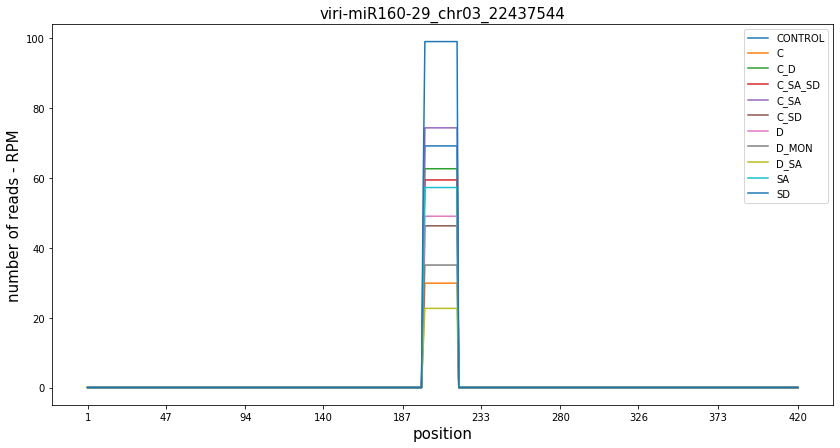

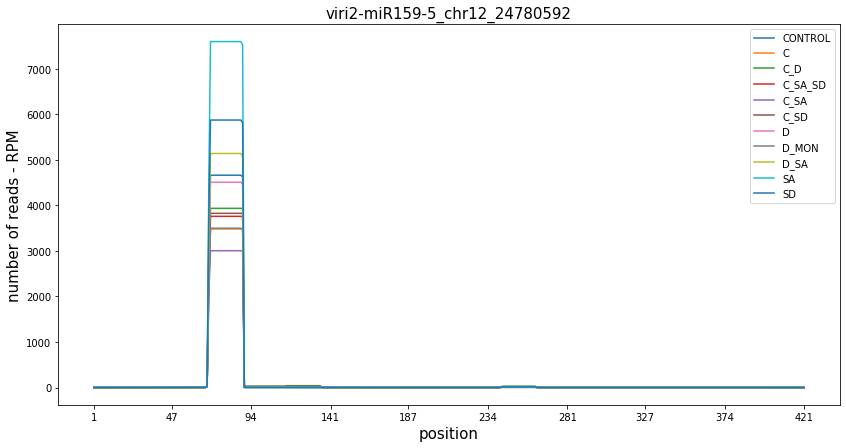

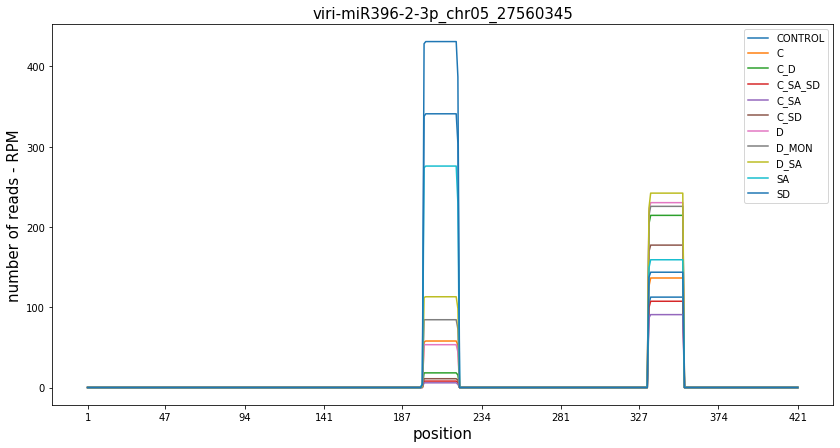

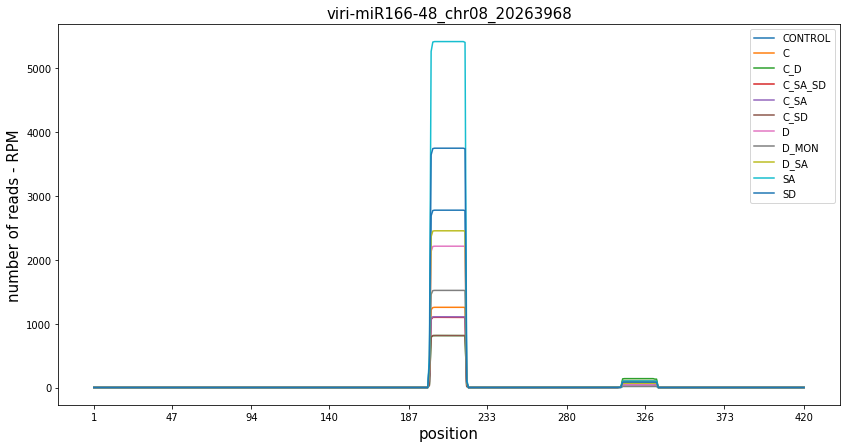

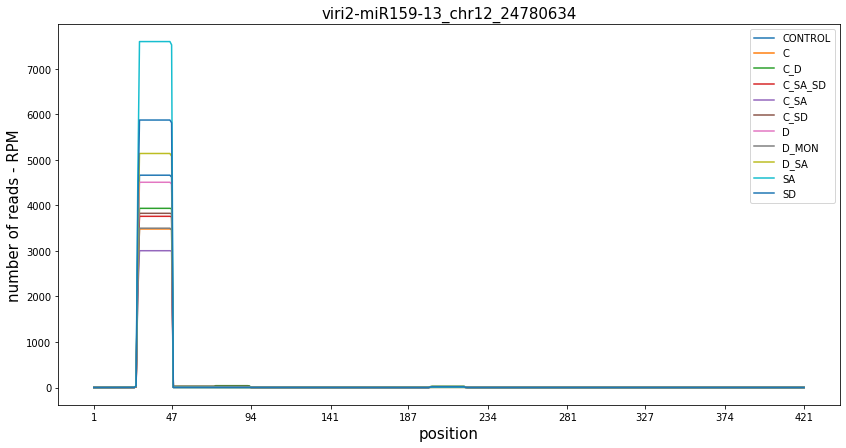

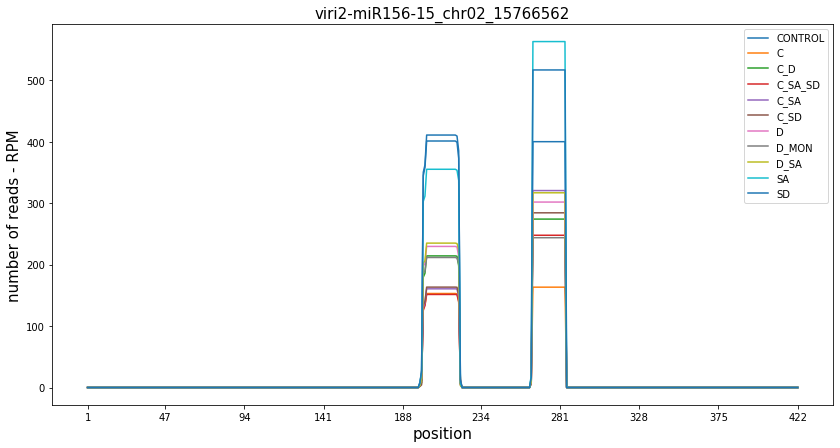

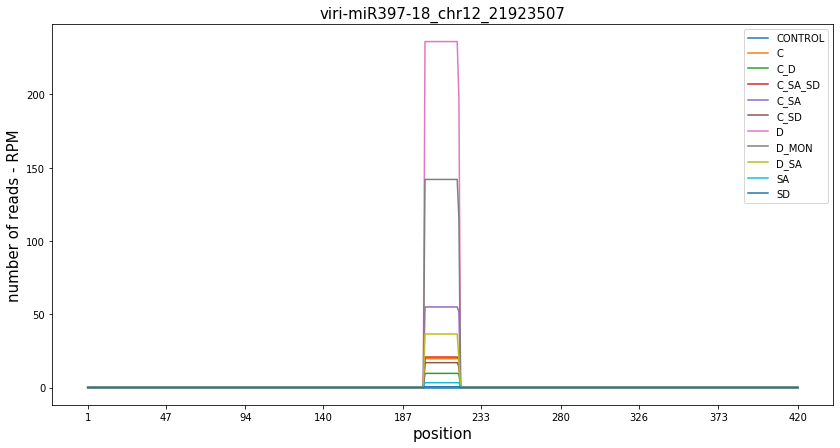

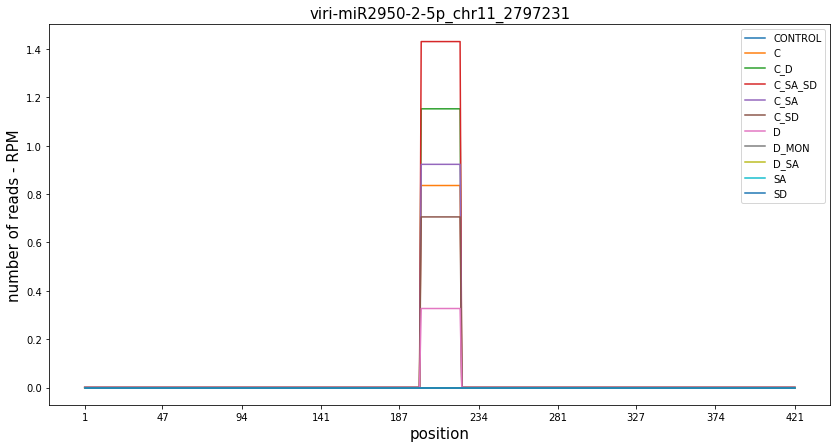

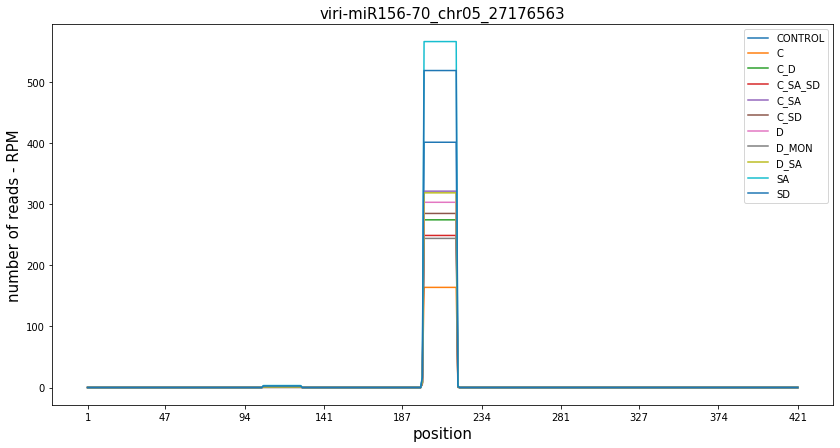

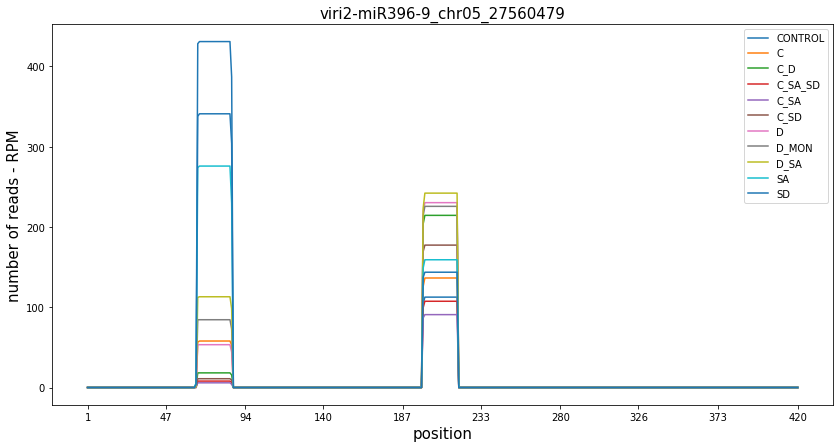

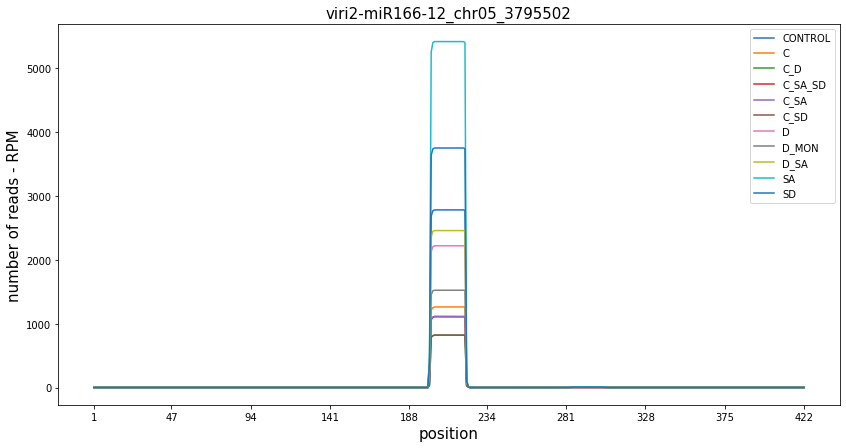

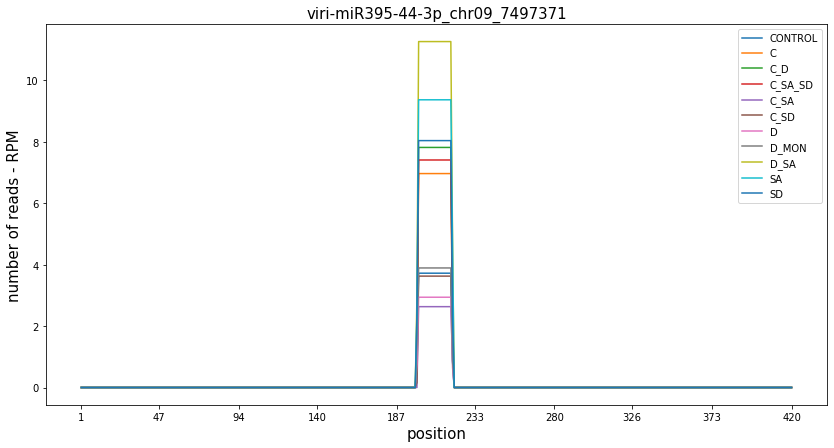

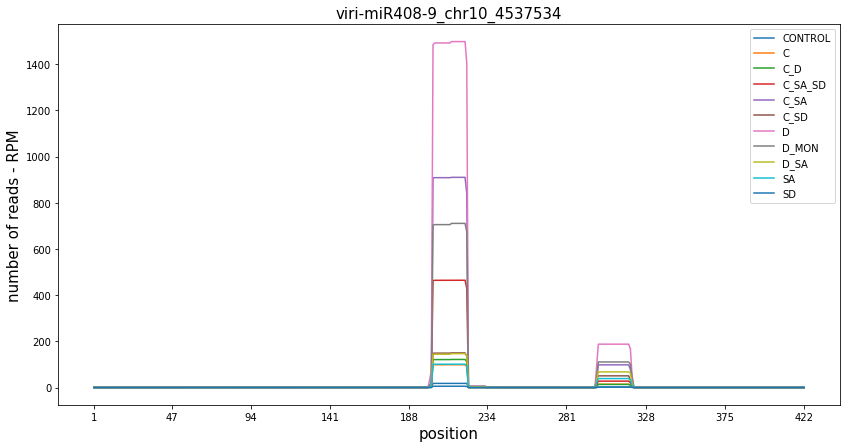

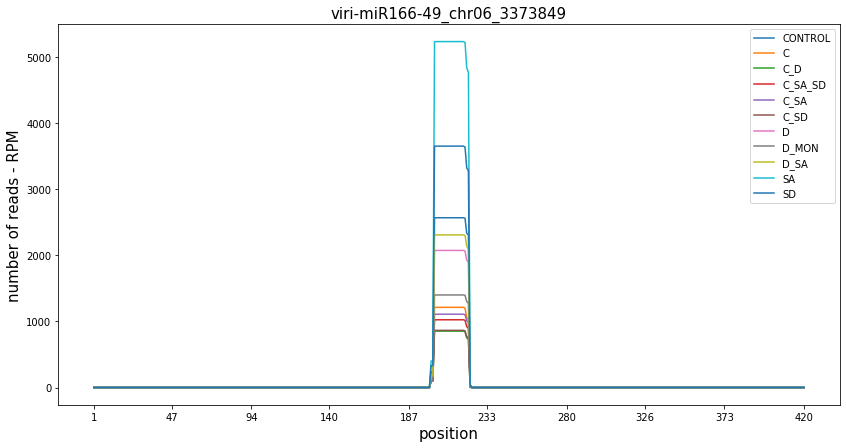

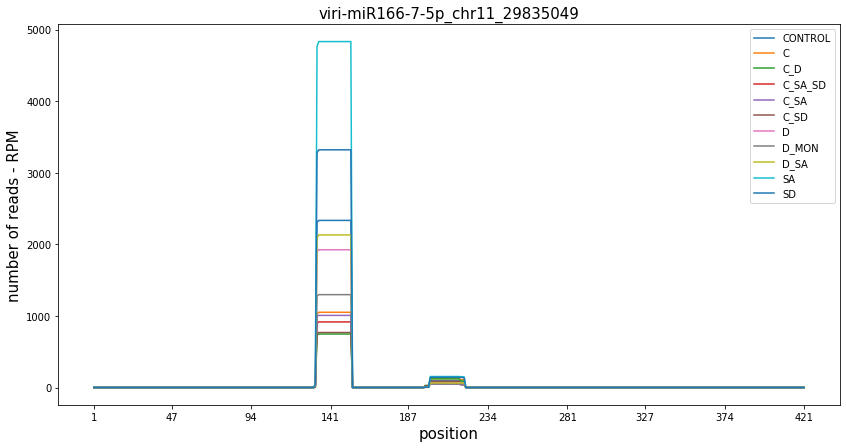

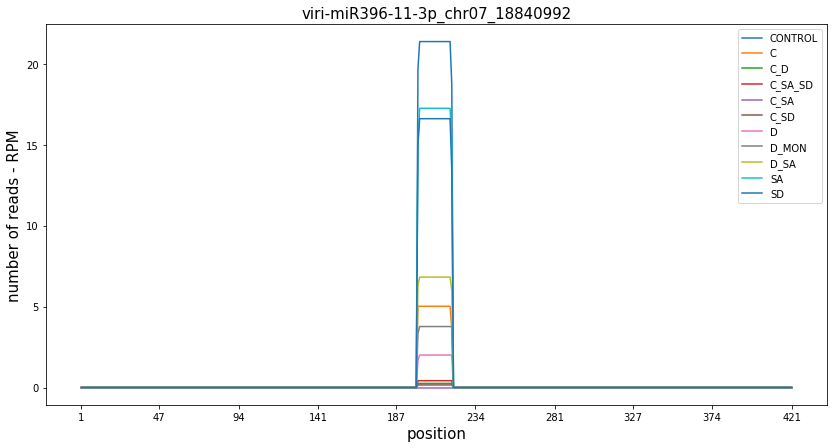

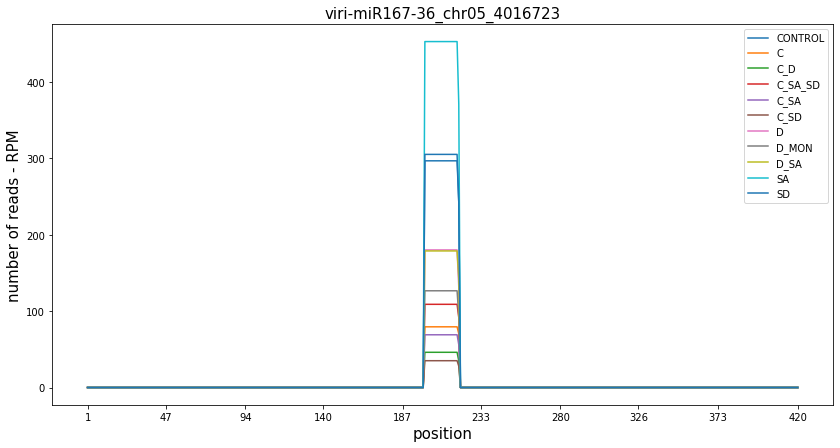

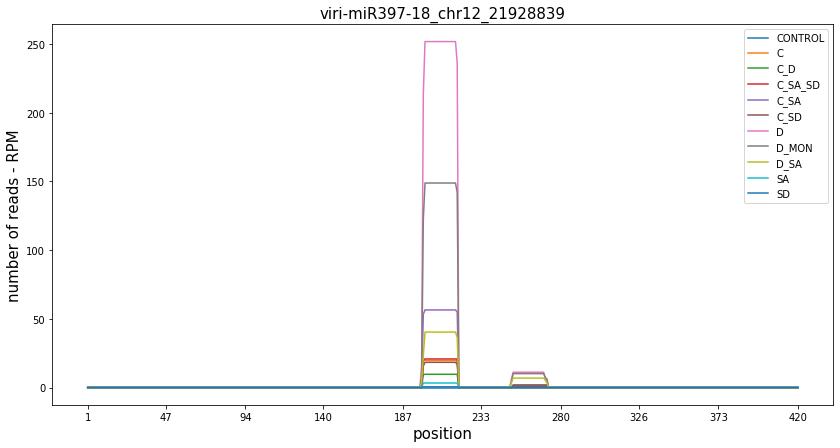

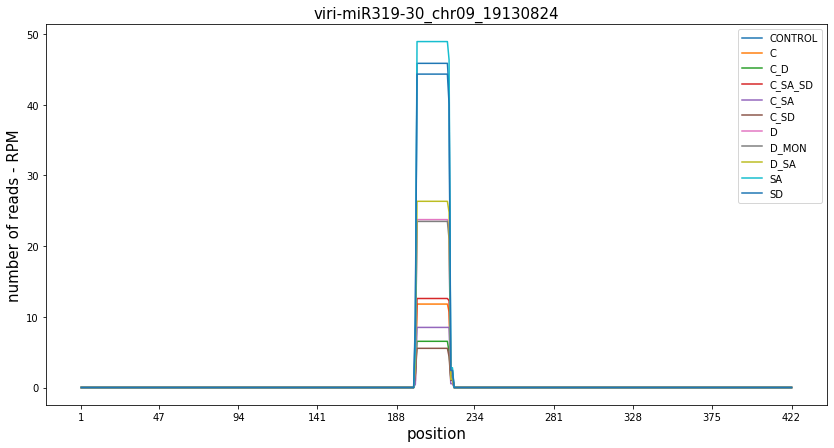

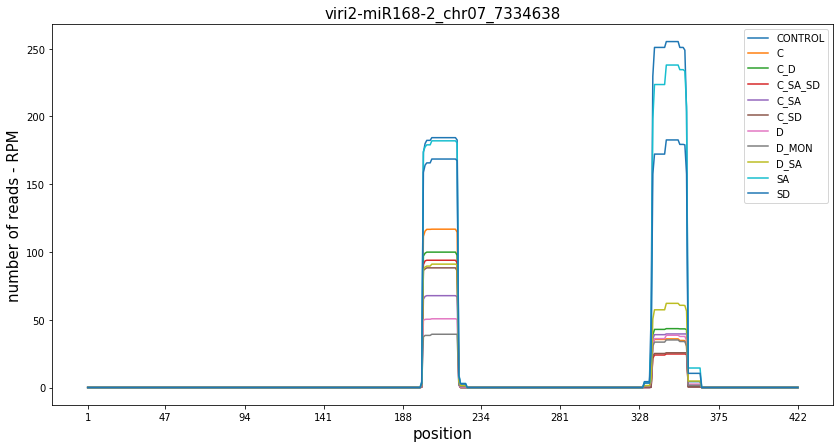

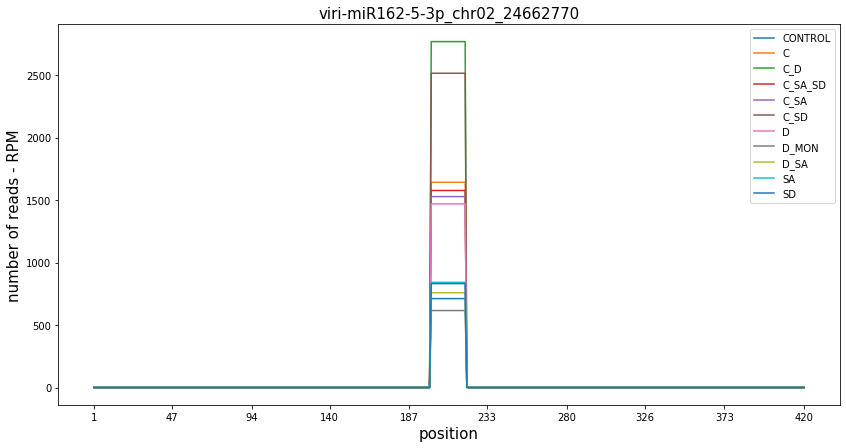

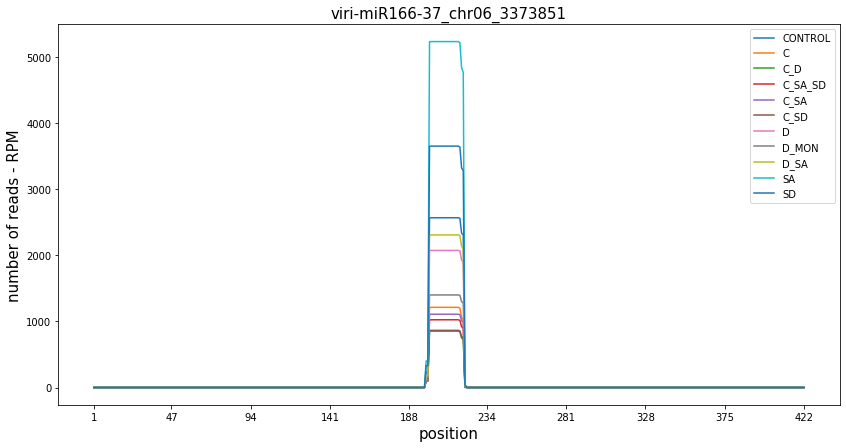

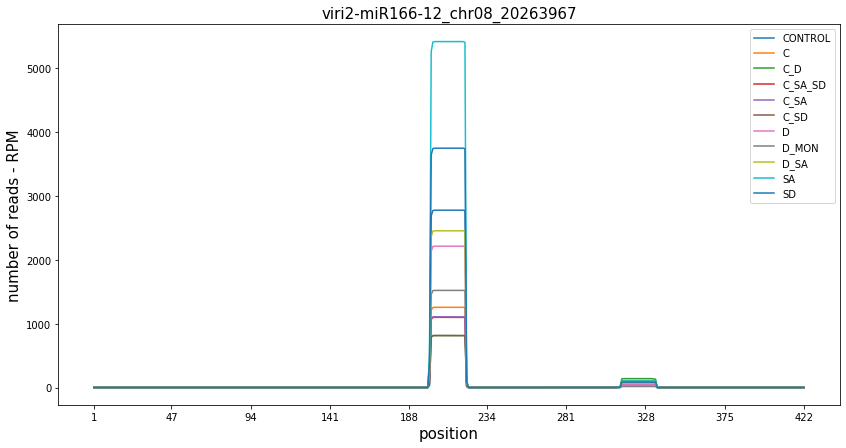

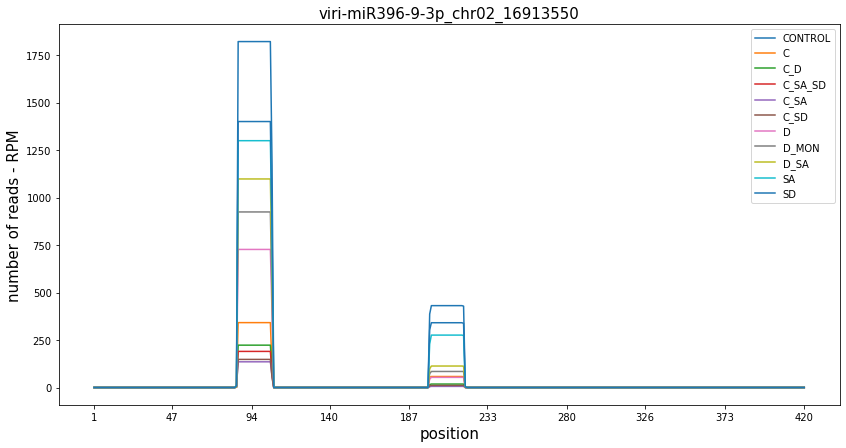

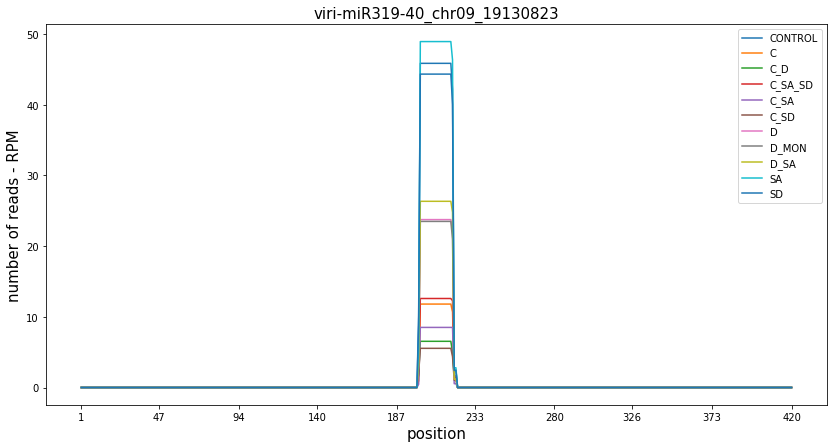

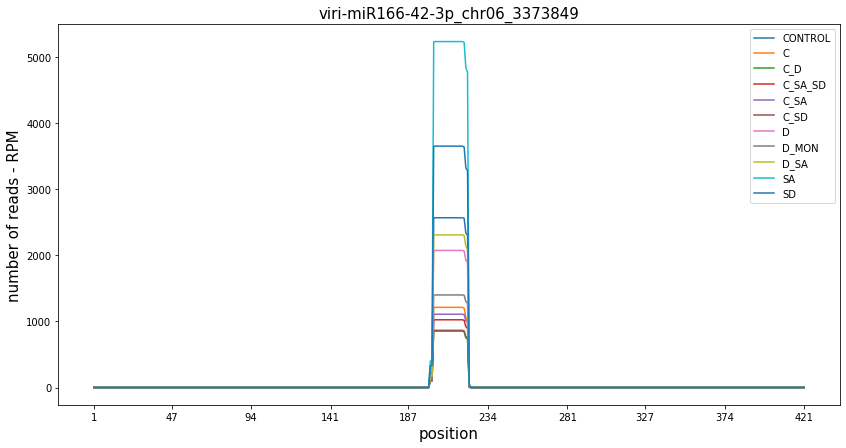

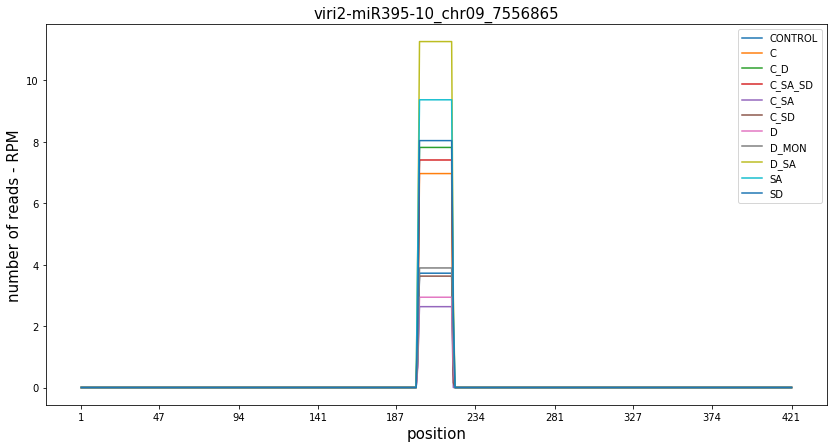

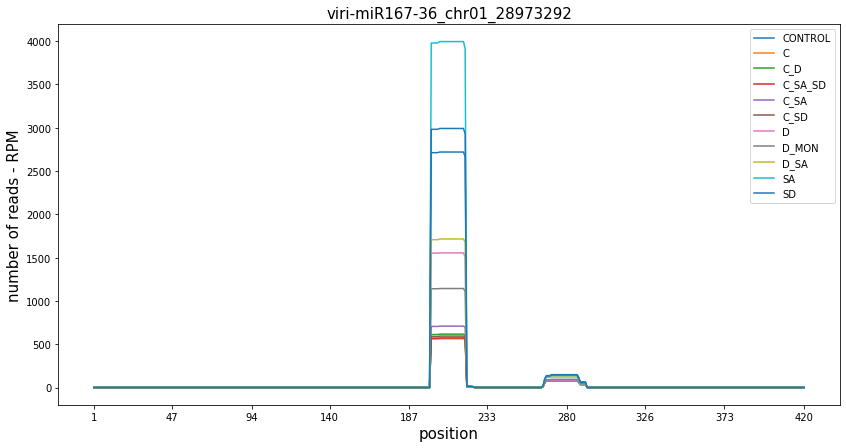

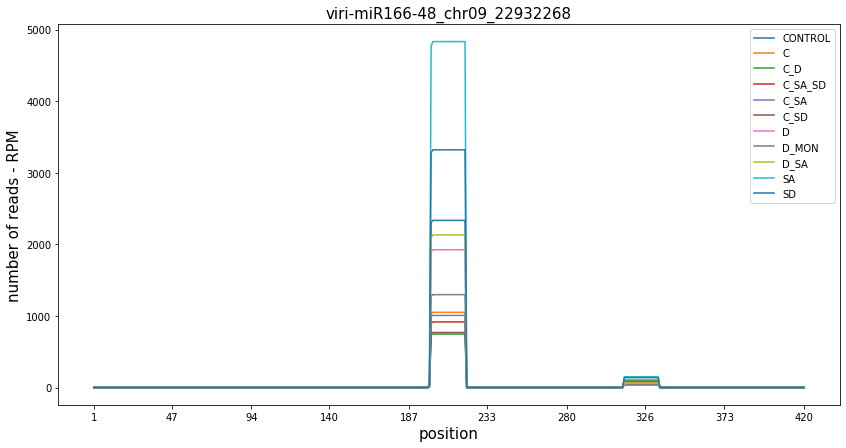

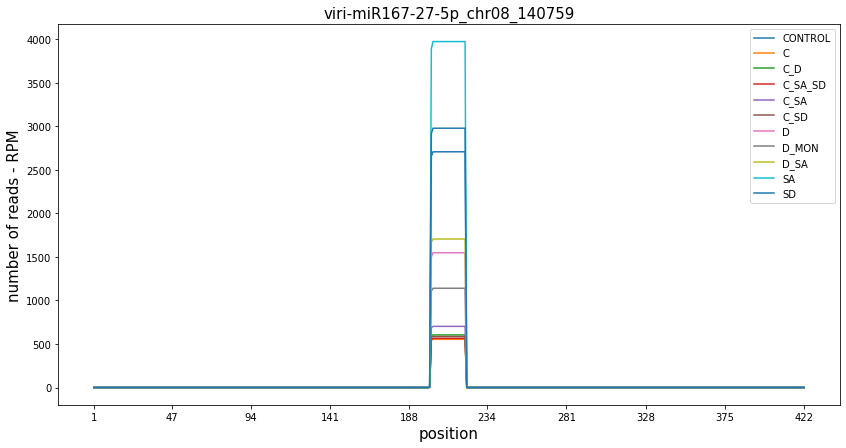

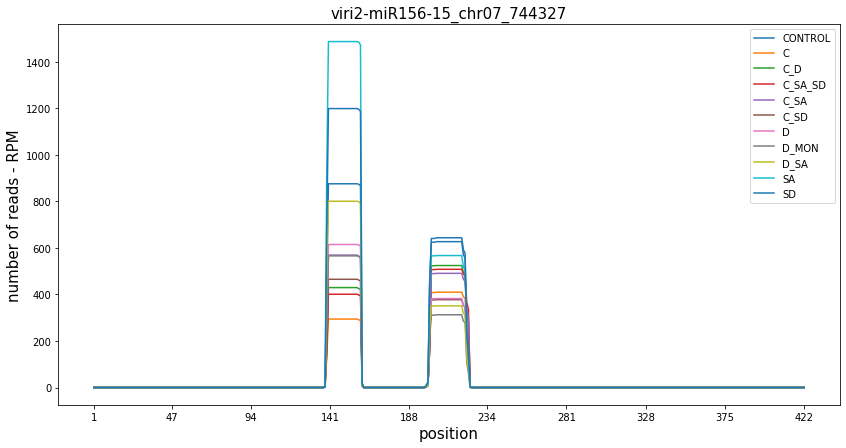

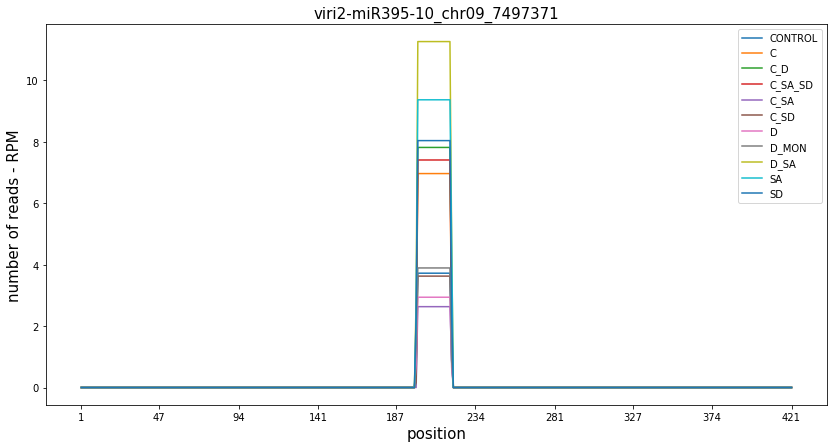

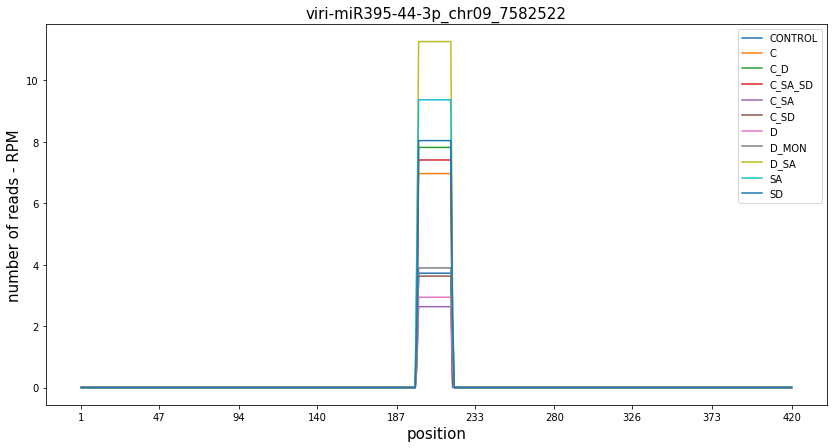

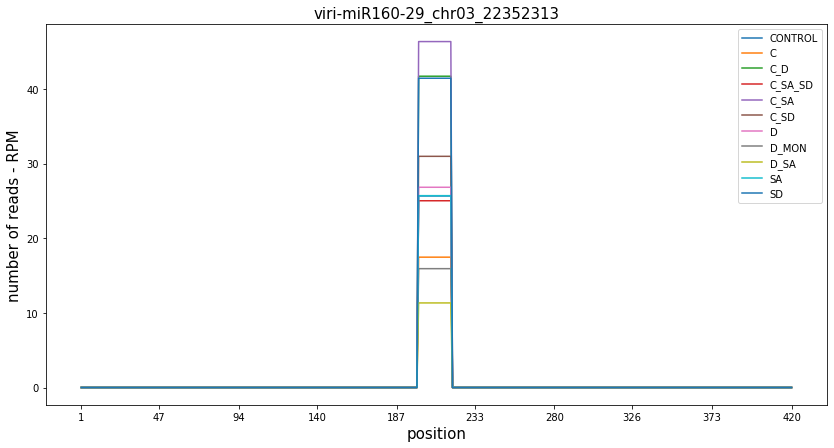

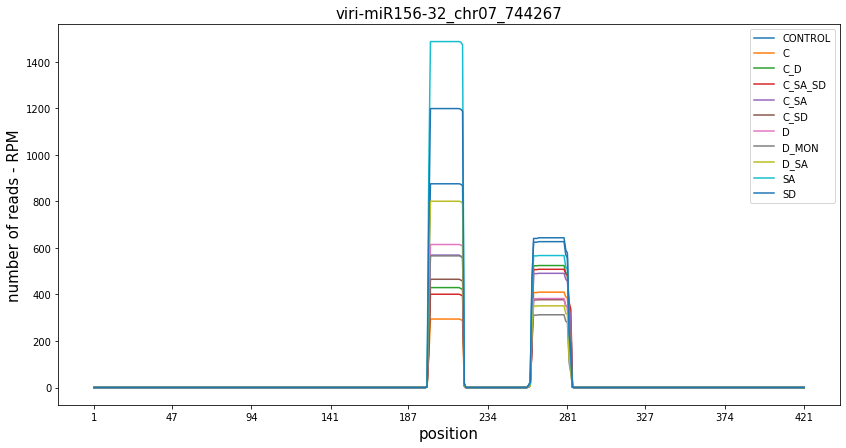

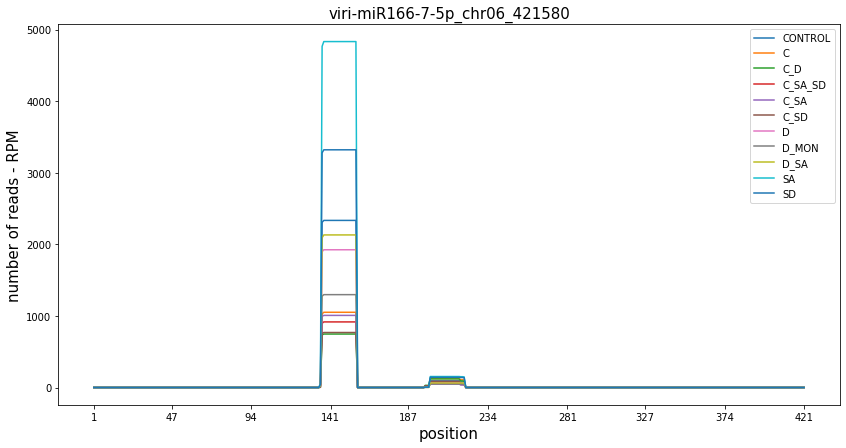

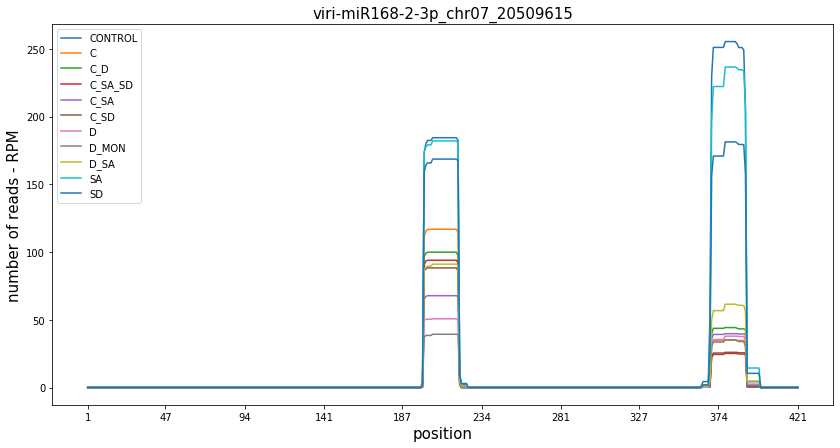

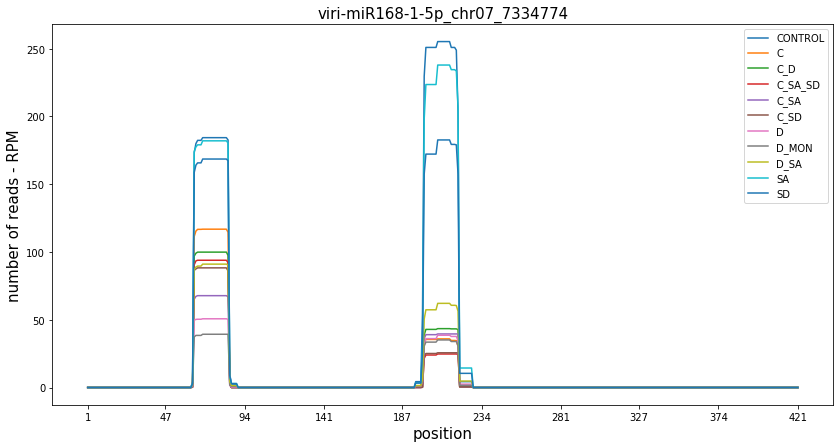

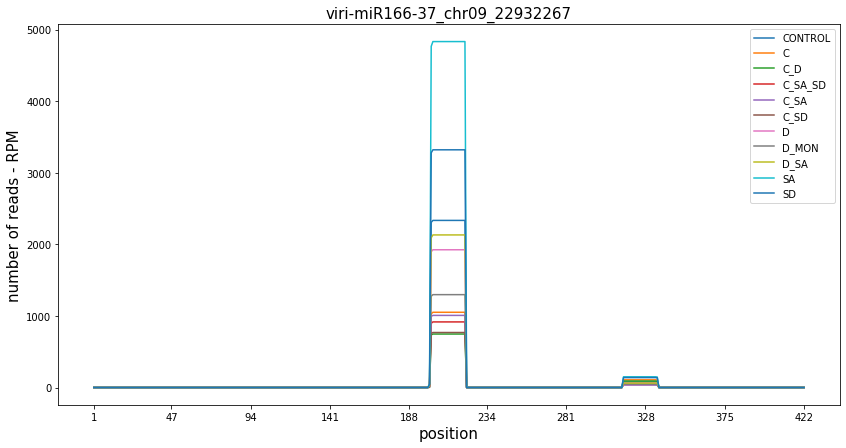

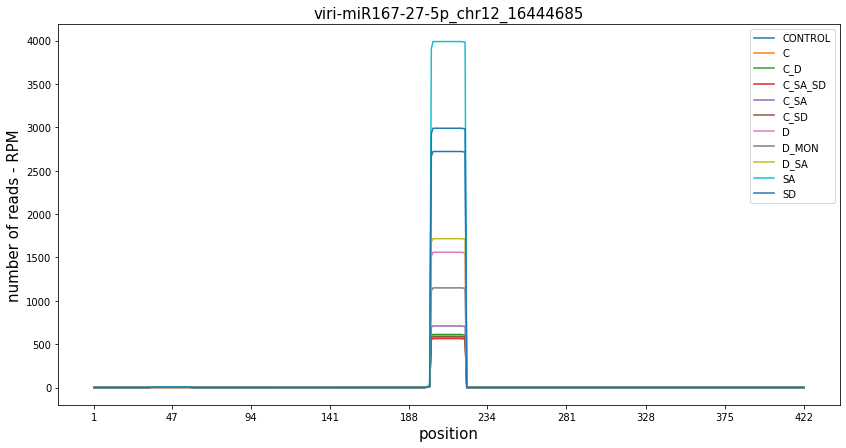

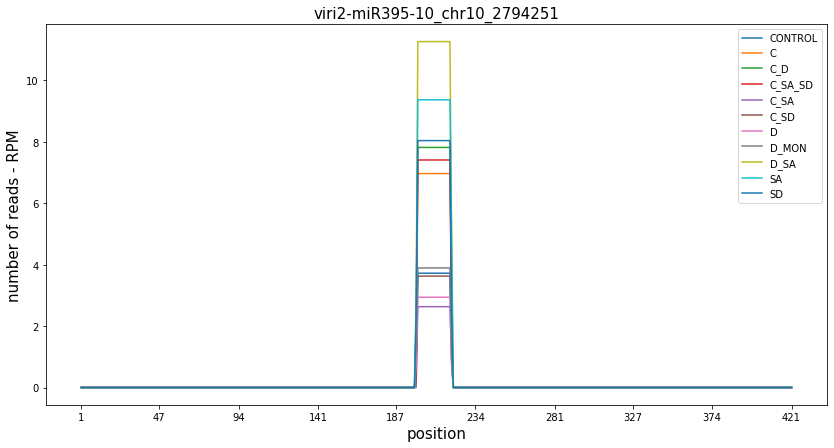

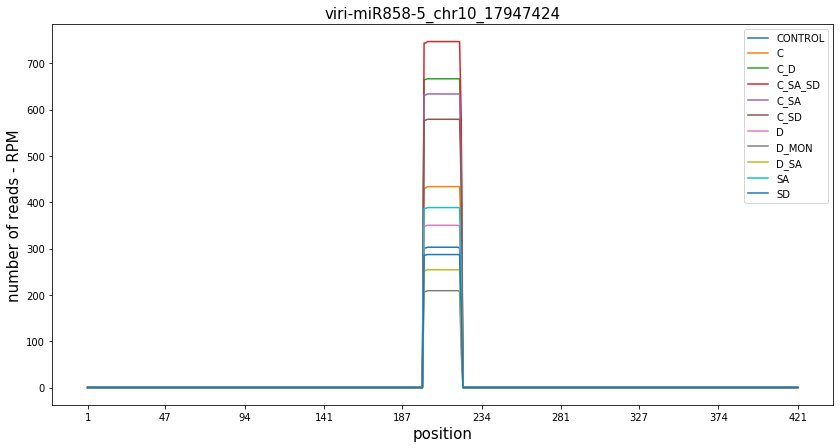

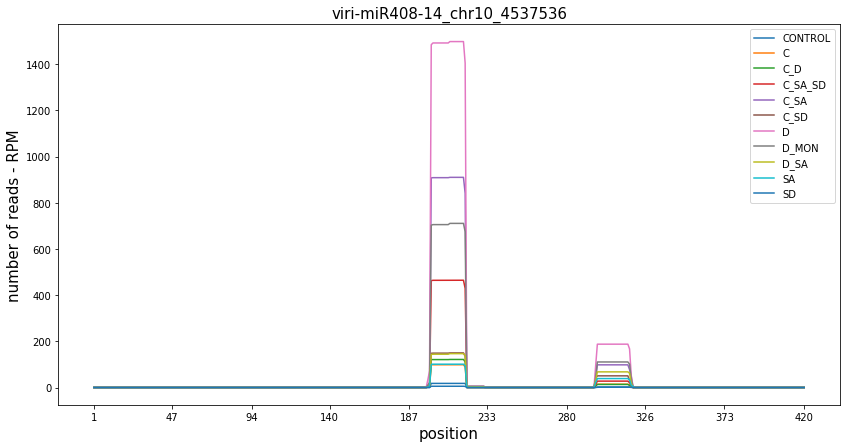

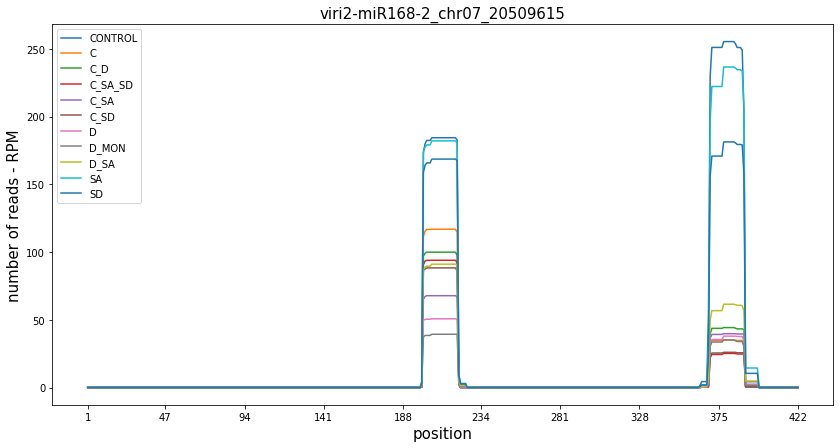

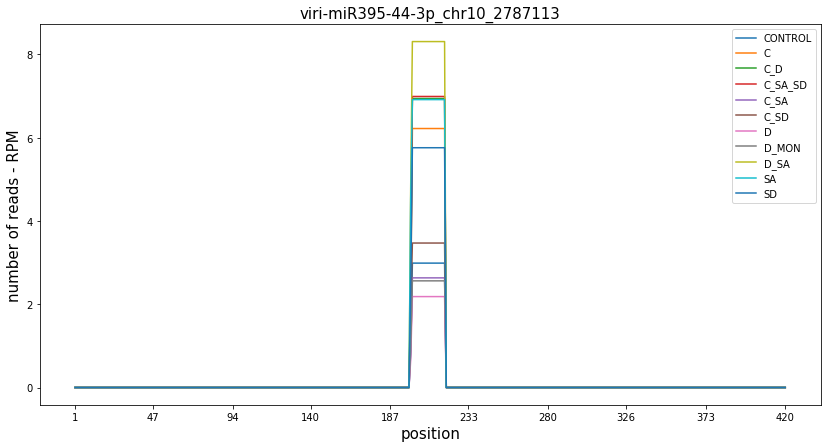

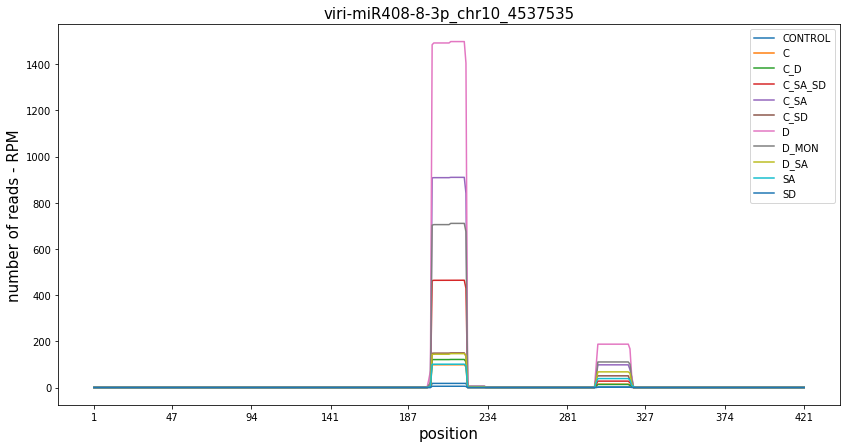

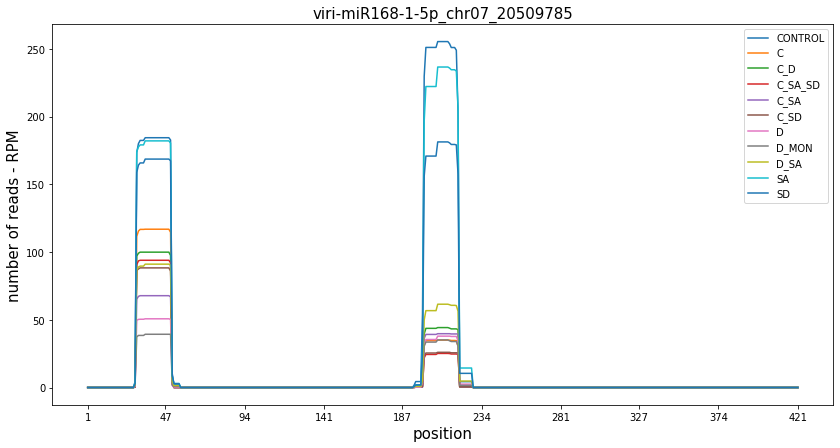

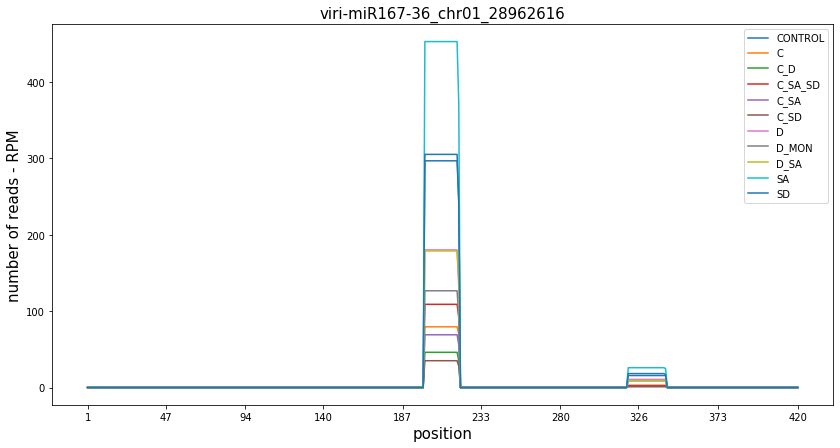

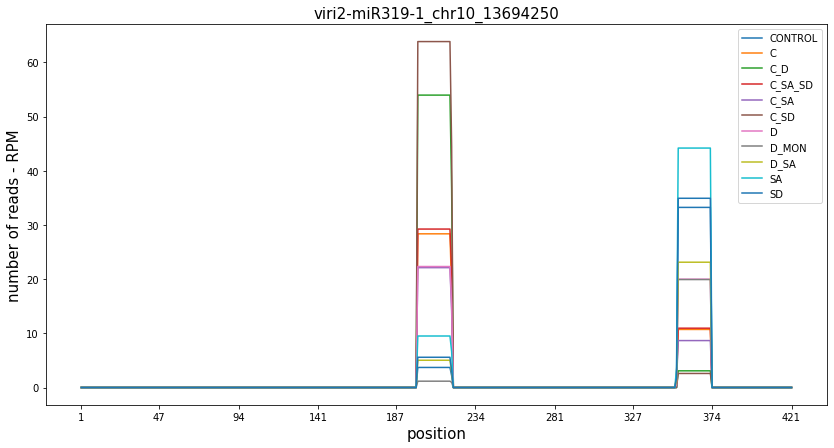

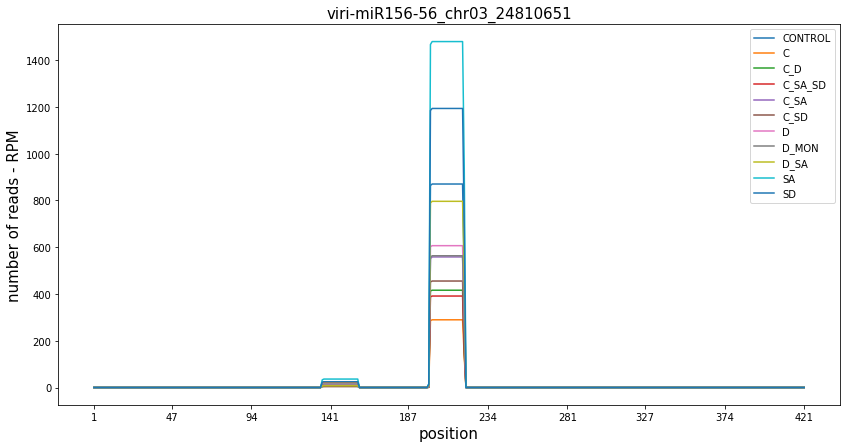

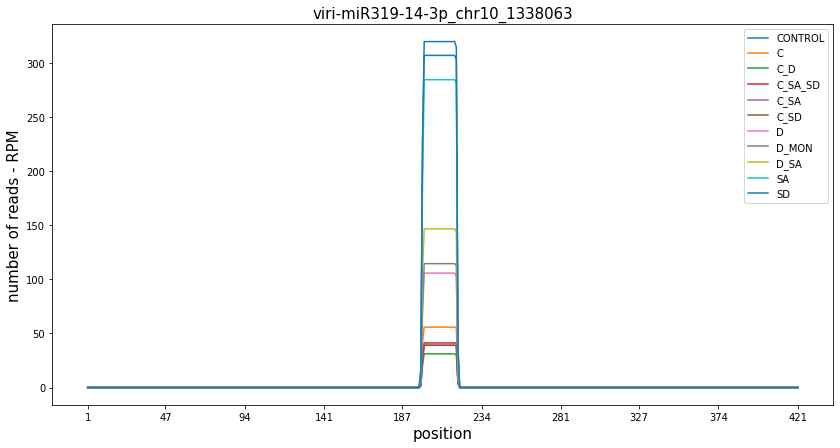

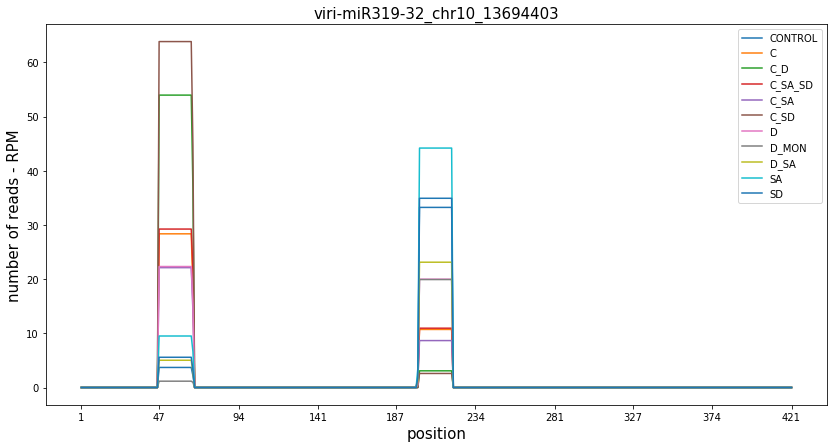

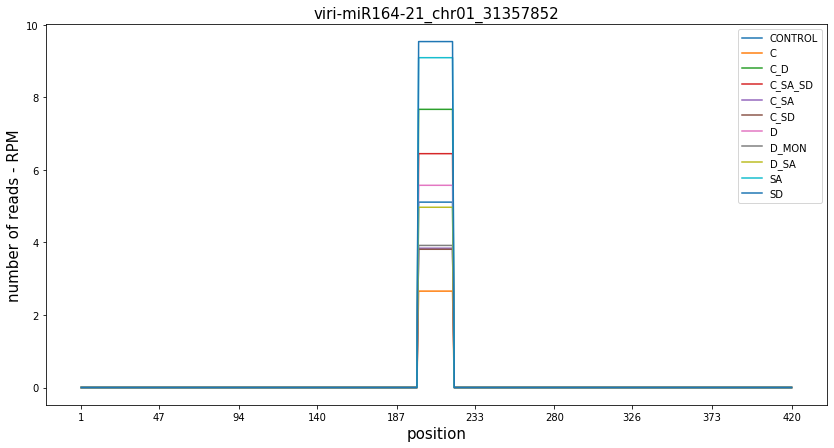

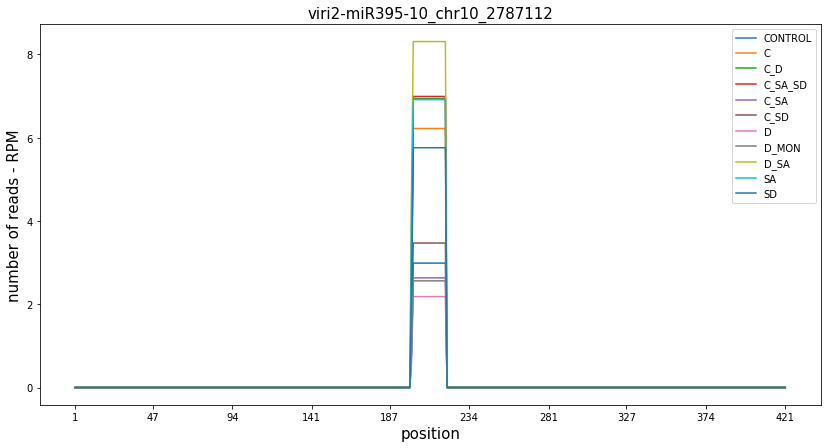

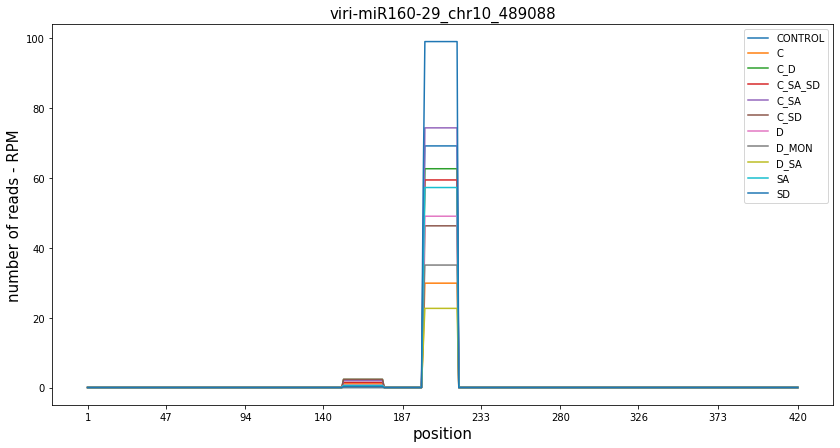

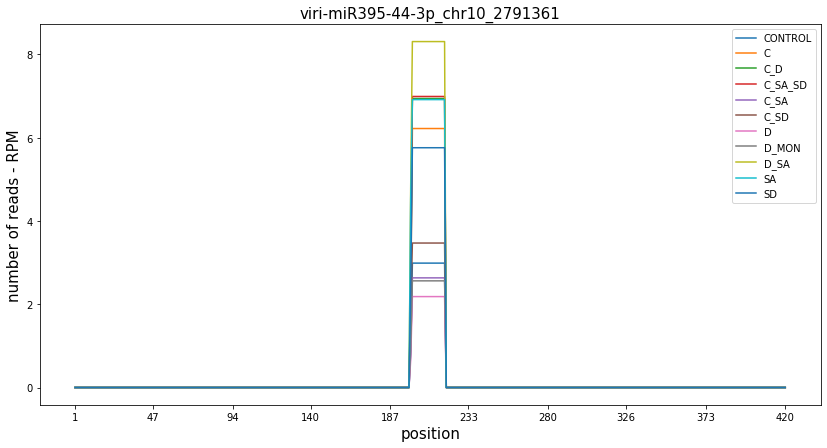

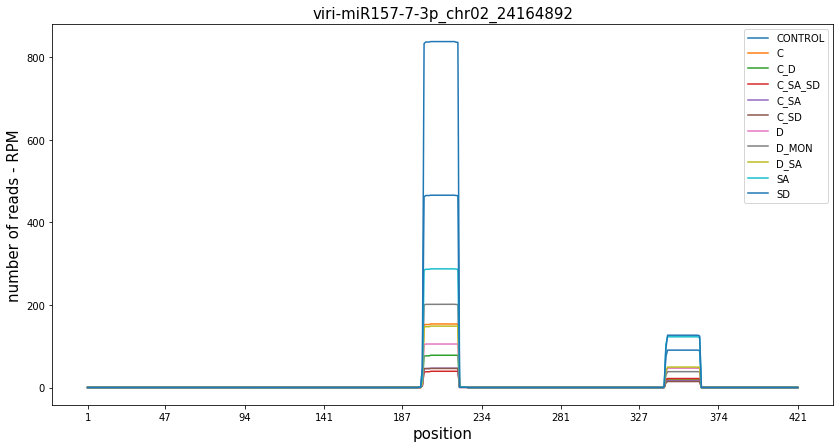

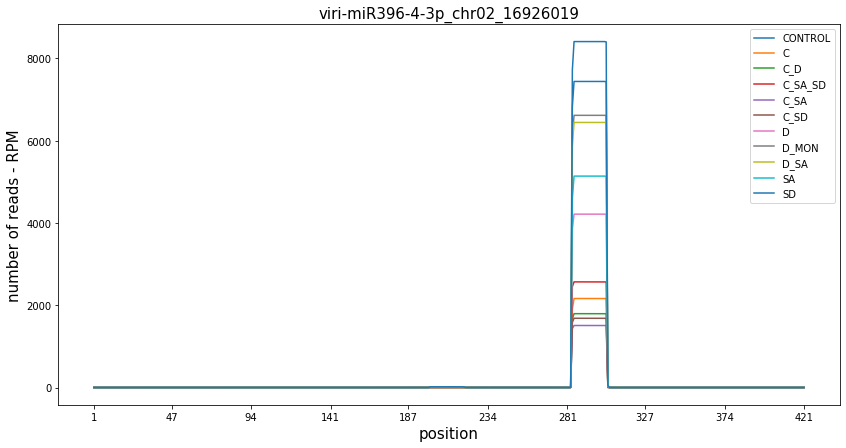

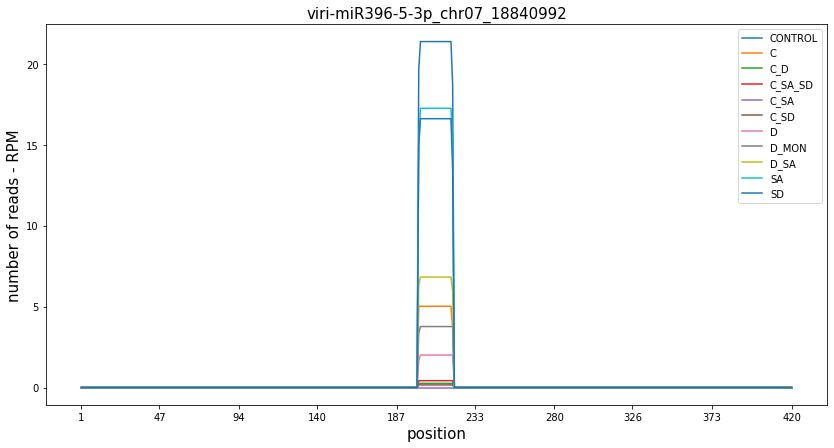

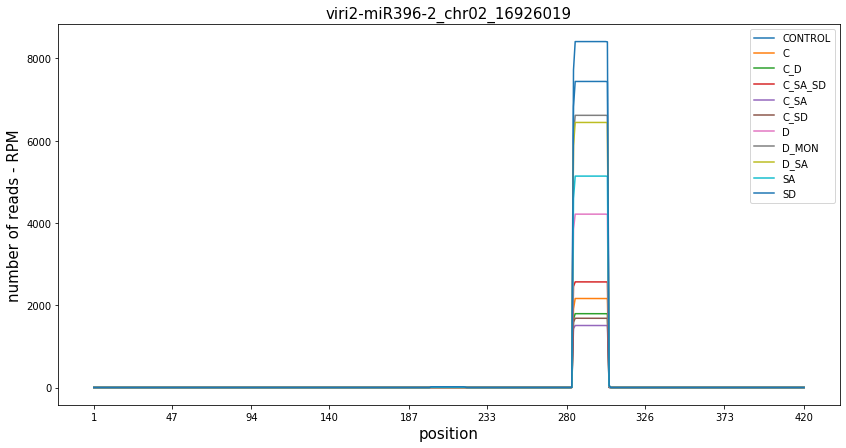

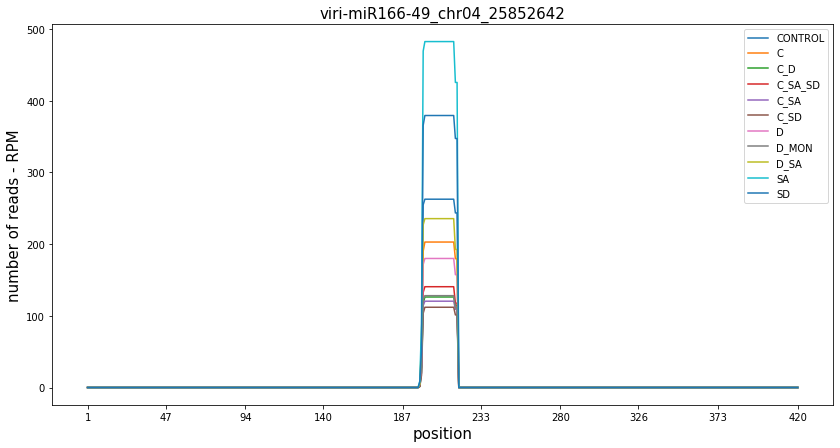

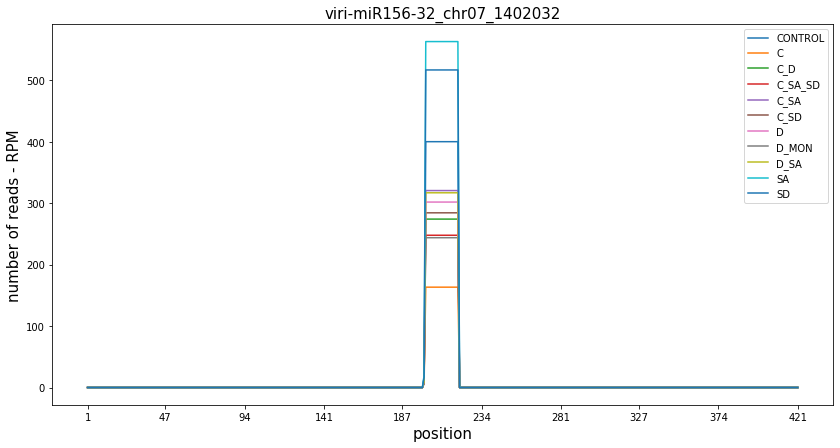

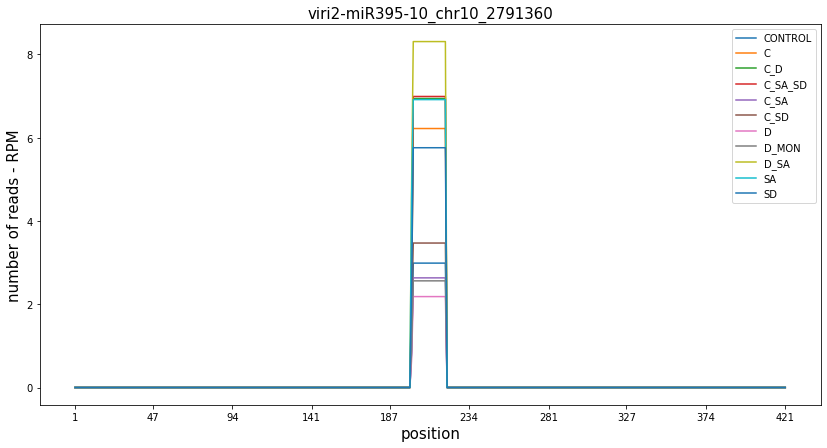

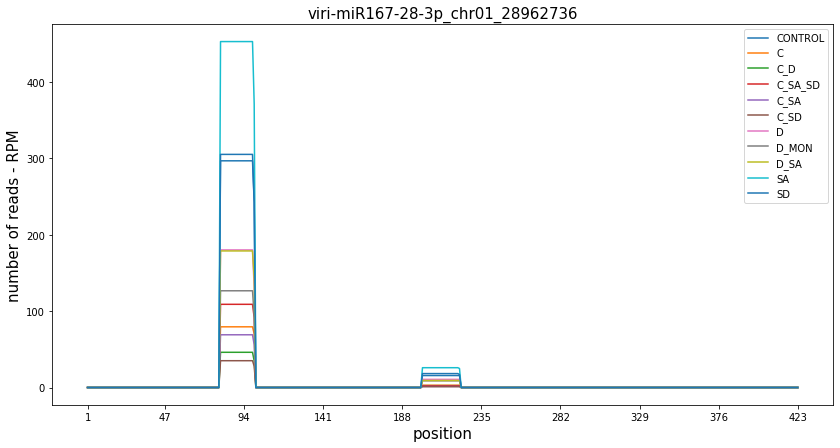

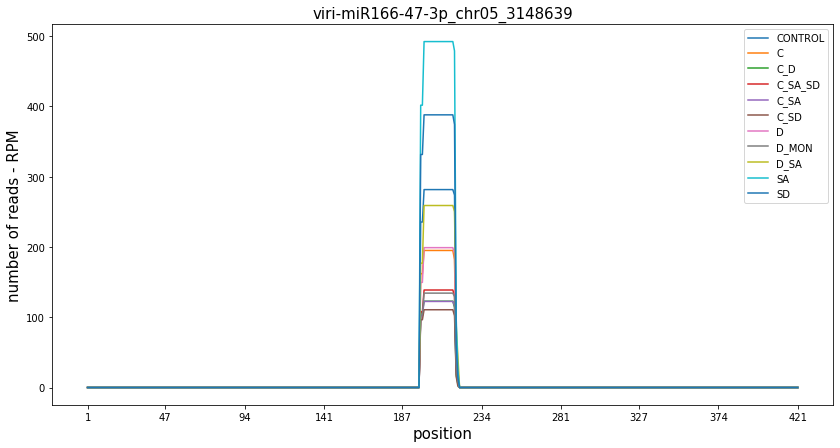

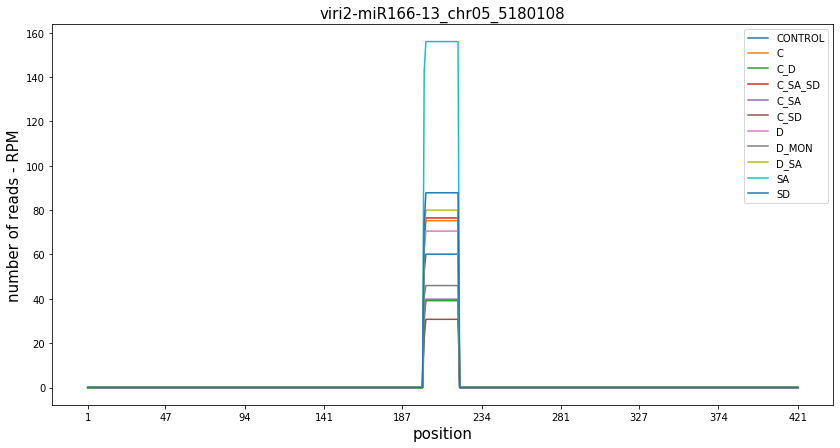

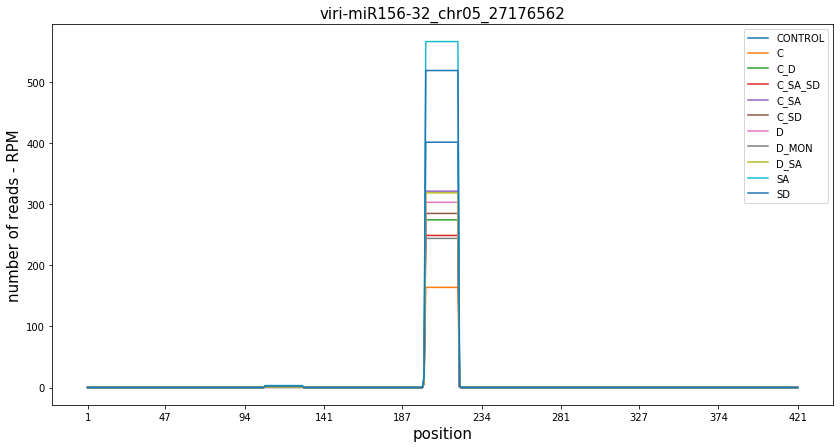

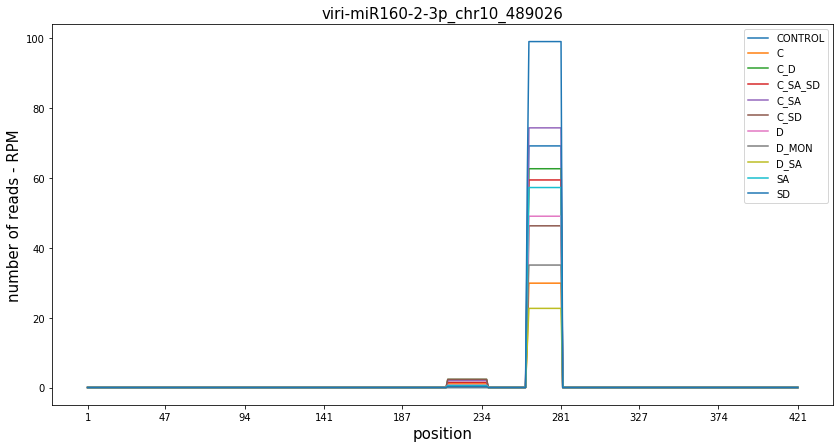

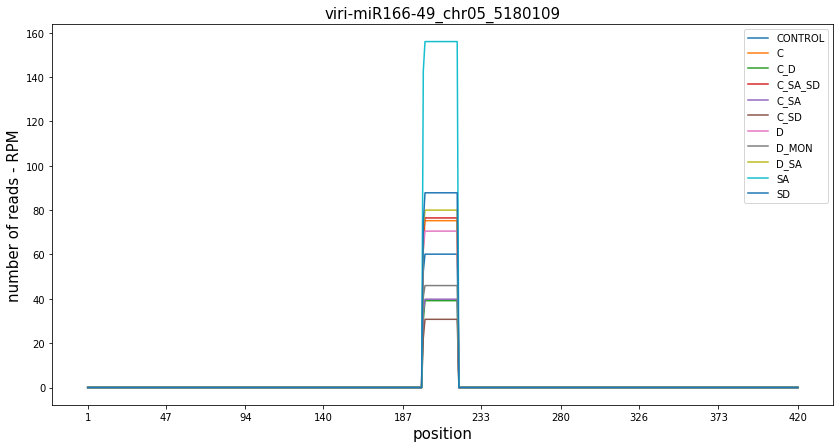

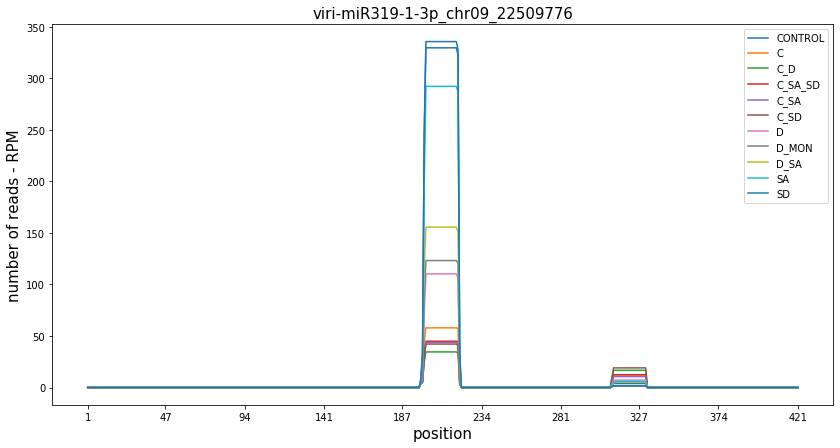

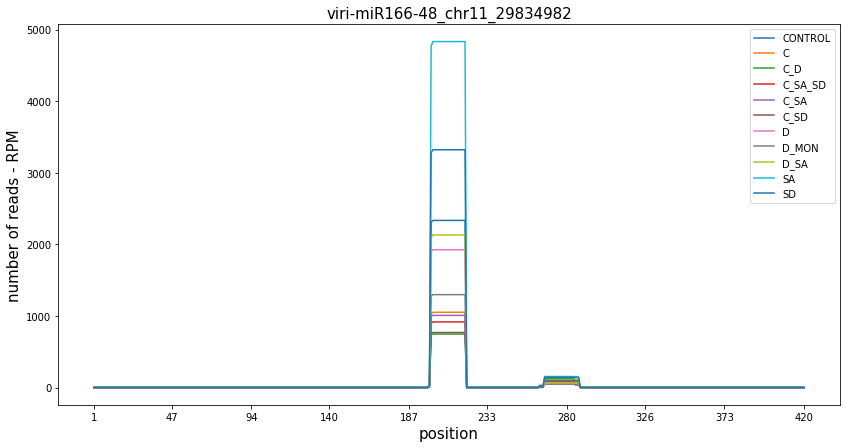

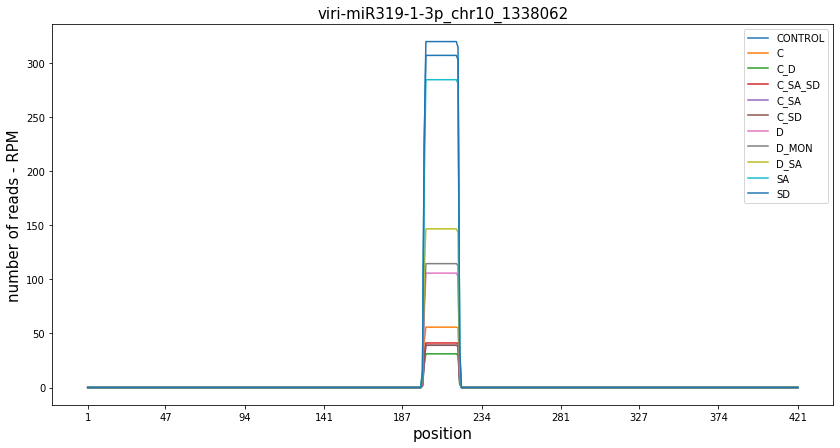

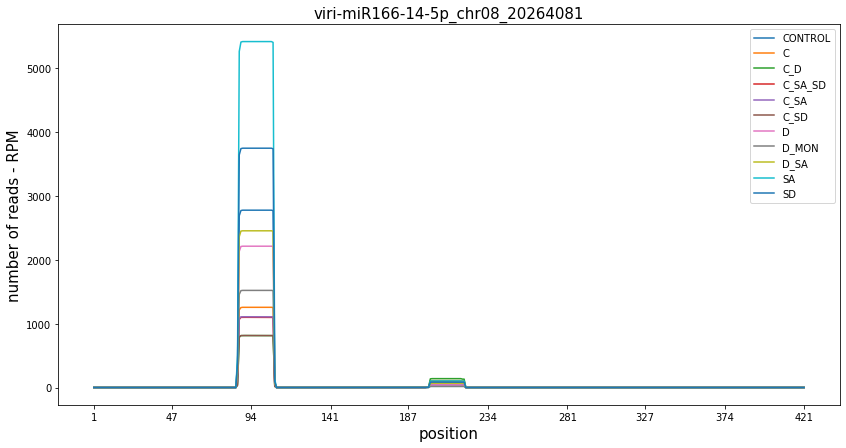

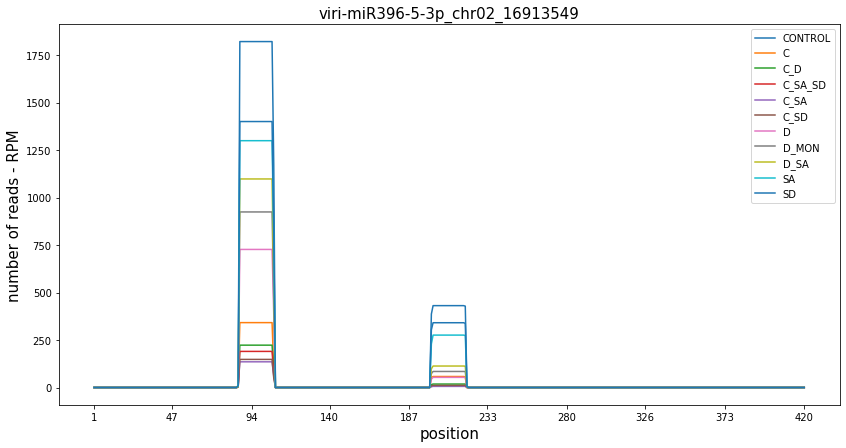

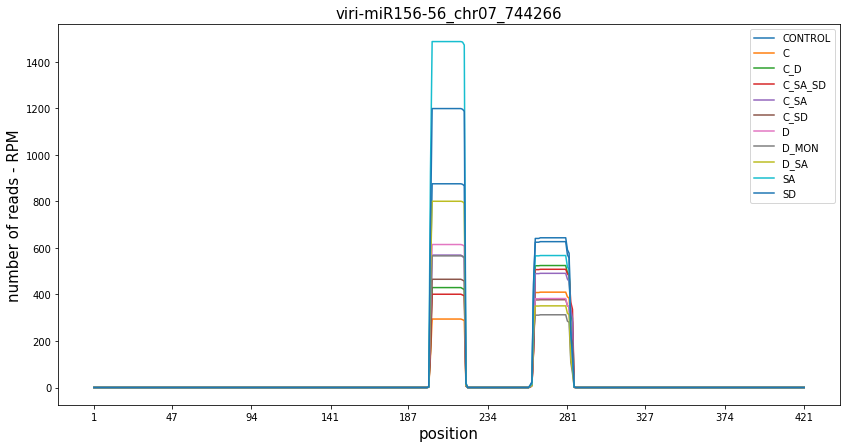

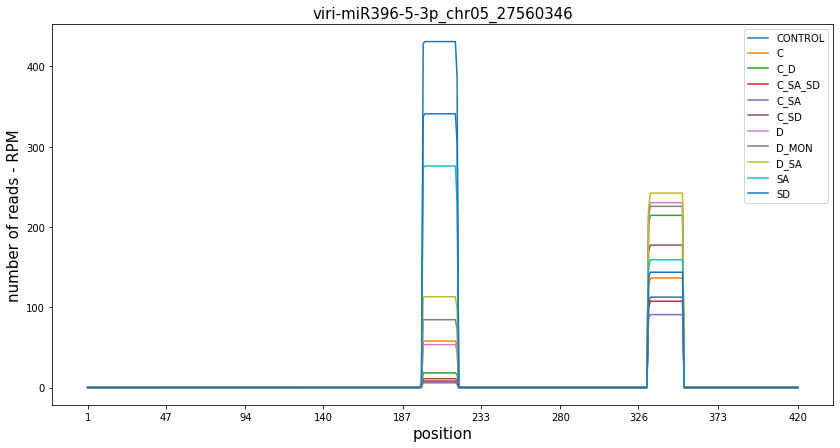

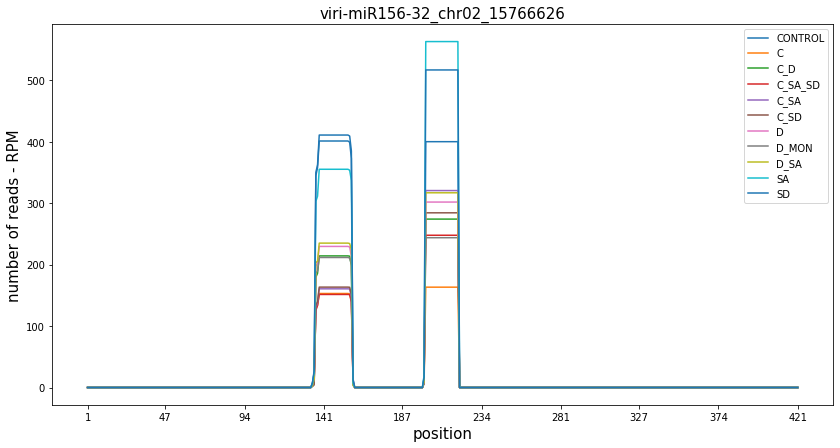

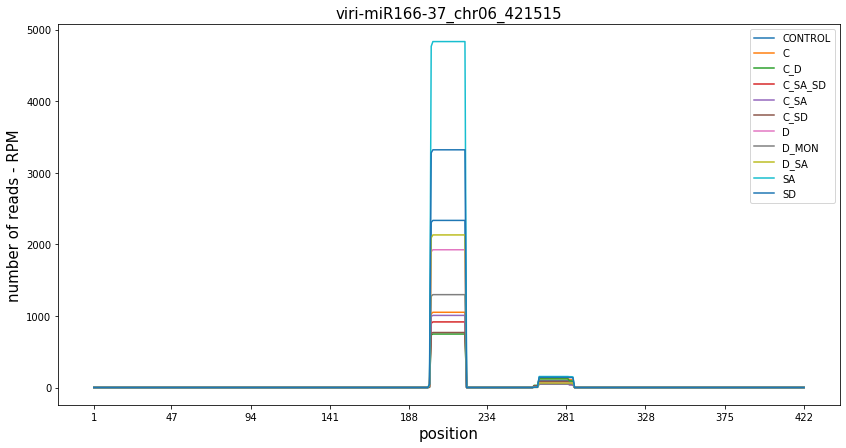

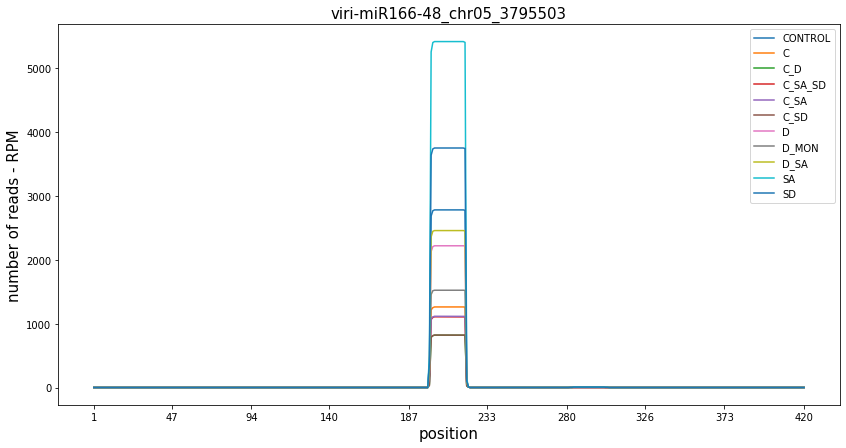

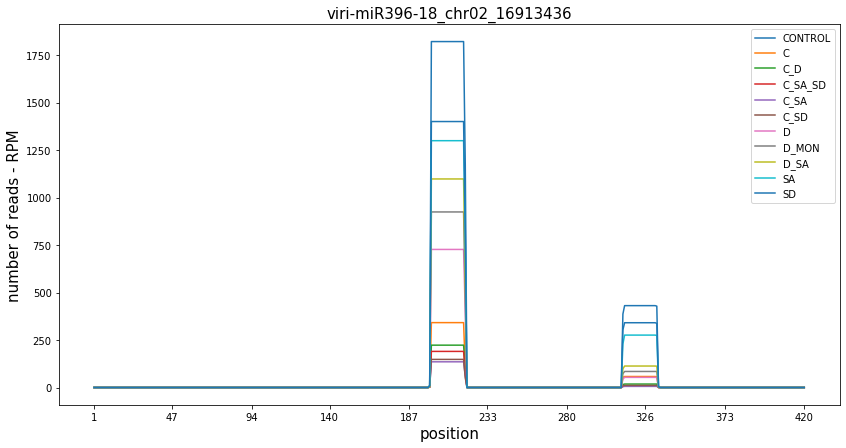

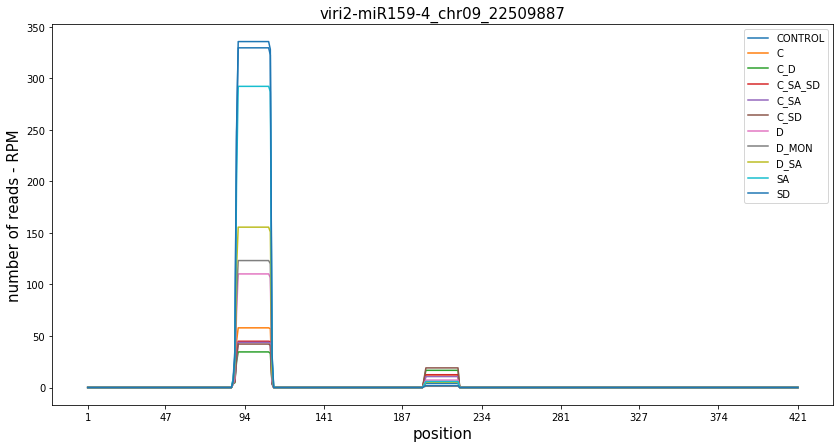

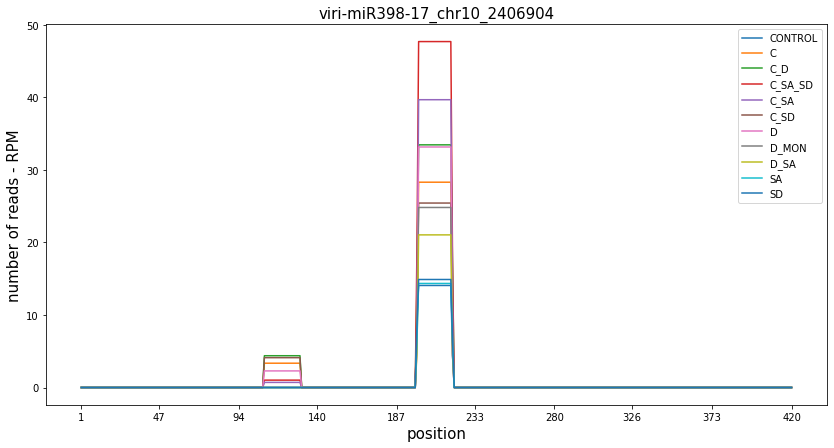

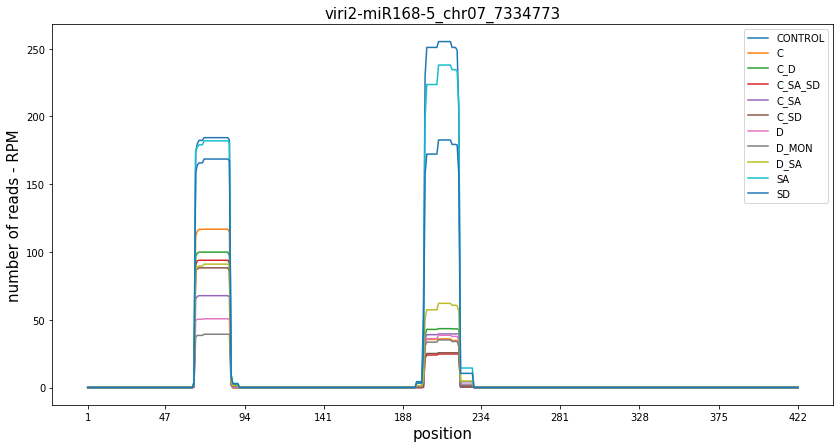

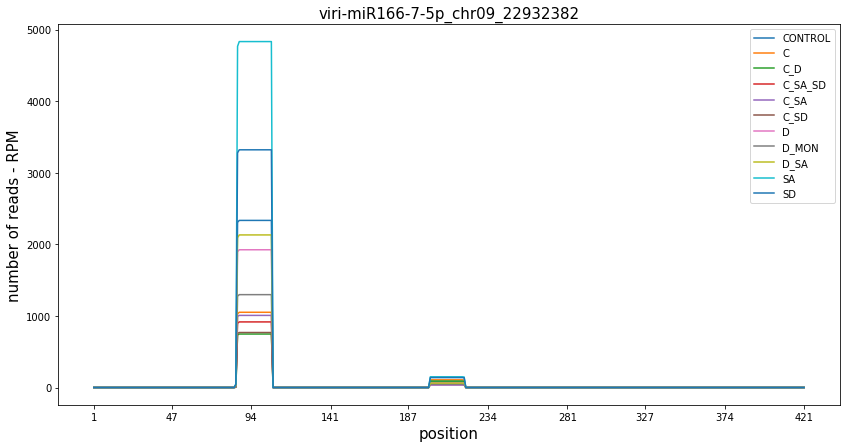

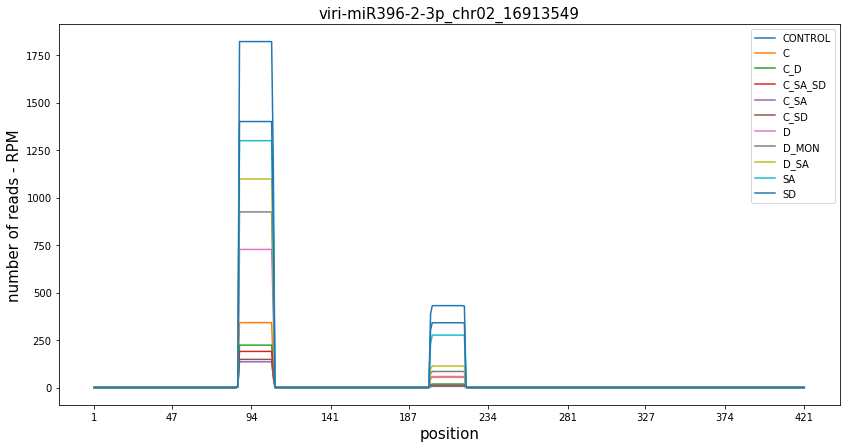

In [70]:
for precursor_cme in list_precursors:
    rows_precursor = set([prec for prec in list(final_table_precursors_counts_diff_exp['Precursor']) if precursor_cme in prec])
    cmels = final_table_precursors_counts_diff_exp.loc[final_table_precursors_counts_diff_exp['Precursor'].isin(rows_precursor)]
    length_col = [i for i in range(1, int(cmels['length prec'].iloc[0])+1)] ## for desde 1 hasta 134 (len prec.)
    column_names = ['CONTROL', 'C', 'C_D', 'C_SA_SD', 'C_SA', 'C_SD', 'D', 'D_MON', 'D_SA', 'SA', 'SD']
    
    base_to_base_prec_dataframe = pd.DataFrame(index=length_col, columns=column_names)
    base_to_base_prec_dataframe = base_to_base_prec_dataframe.fillna(0)

    mean_counts_names = [x for i,x in enumerate(cmels.columns) if 'MEAN' in x]

    mean_counts_names.insert(0,'start')
    mean_counts_names.insert(1,'length seq')
    mean_counts_names

    data = cmels[mean_counts_names]

    new_colnames = [x[5:] for i,x in enumerate(cmels.columns) if 'MEAN' in x]

    mean_counts_names[2:] = new_colnames

    data.columns = mean_counts_names

    try:
        for row in range(len(data)):
            start_pos = int(list(data.iloc[row,:])[0])
            end_pos = start_pos + int(list(data.iloc[row,:])[1])
            for base in range(start_pos, end_pos): 
                # Le resto 1 porque la lista de bases en el df empieza en la posición 0, no 1
                base_to_base_prec_dataframe.iloc[base-1] = base_to_base_prec_dataframe.iloc[base-1].fillna(0) + data.iloc[row][mean_counts_names[2:]].fillna(0)
    except:
        print('%s has given an error indexing in line 29' %precursor_cme)
    base_to_base_prec_dataframe = base_to_base_prec_dataframe.fillna(0) # cambiamos NA por 0

    plt.figure(figsize = (14,7))
    for i in base_to_base_prec_dataframe.columns:
         plt.plot(base_to_base_prec_dataframe.loc[:,i], label = i)

    plt.title('%s' %precursor_cme, fontsize = 15)
    plt.xlabel('position', fontsize = 15)
    plt.xticks(np.linspace(1,len(base_to_base_prec_dataframe),10, dtype = int))
    plt.ylabel('number of reads - RPM', fontsize = 15)
    plt.legend()
    plt.savefig('/home/lab205/Desktop/LLUIS/Results/08-sRNA_hairpin_alignment/T4_plots/estreses_dobles/%s.jpg' %precursor_cme)
